# Market Analsis and New Product Recomedation for Digital Media Market using Deloitte Digital Democracy Data

### Project Overview

#### Executive Summary
The purpose of this project was to identify specifications for a new product that could be created in order to ensure a good market fit. Based on the information from the following data analysis we found that the most interesting market to move into could be mobile sports streaming.

#### Problem
With an overwhelming amount of information on consumer habits and a very congested streaming market, it might be difficult to determine specific markets to which we can advertise the product. 

#### Solution
We explore customer habits to see how to cluster them into potential customer groups and explore what are the potential ways to break into the market by observing the trends over the years.

#### Data Overview
Deloitte Digital Democracy Survey results which we used for years 2009-2011 contained answers to approximately 190 questions for over 2000 respondents each year. A lot of the columns contain a lot of messy information that needs to be first cleaned in order to reach meaningful conclusions. For this project, we specifically focused on survey data on consumer demographics, current device usage, current mobile phone app usage and media consumption pattern responses.

#### Modeling Preparation
We first prepare the data by changing survey responses to numerical answers and then group the information to help aggregate responses by different demographic groups. We ensure that there are no missing values and that the columns are meaningful and understandable.

#### Modeling Approach
We cluster survey respondents using the K-means algorithm and evaluate the clusters using silhouette scores. For time-series analysis, due to the lack of granularity in our data, we explore simple changes over time, such as average year-over-year changes in device usage and media consumption.

#### Results 
We found a number of interesting correlations in terms of changing app usage and the groups that are using them. We discover that one area that might provide a lot of untapped potential is mobile sports streaming, which seems to be growing dramatically and caters to a relatively narrow, but passionate higher-income consumer groups.

#### Result Evaluation
We evaluate our clustering results based on the silhoutte scores and through normalization of scores for the time-series.

#### Next Steps
For our next steps we would like to (A) evaluate and identify better sub-clusters using additional demographic and/or market data, (B) test our prototype through in-depth A/B testing to finalize product features.

#### Analysis Organization

1. Initial Data Cleanup
2. Customer Analysis: Current Device Ownership
3. Customer Analysis: Smartphone App Usage
4. Time Trend Analysis

-------------------------------

### 1. Initial Data Cleanup

In order to prepare the information for further analysis we first import necessary packages and prepare the dataframes.

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from datetime import datetime
from IPython.display import Markdown,display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
#Initializing a set of colors for displaying text in the Jupyter Notebook
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
   MAGENTA = '\033[35m' 
    
colors = [color.PURPLE, color.GREEN, color.DARKCYAN,color.YELLOW, color.RED, color.BLUE, color.CYAN,color.MAGENTA]    

In [3]:
#Import files

survey_09 = pd.read_excel("DDS9_Data_Extract_with_labels.xlsx")
survey_10 = pd.read_excel("DDS10_Data_Extract_with_labels.xlsx")
survey_11 = pd.read_excel("DDS11_Data_Extract_with_labels.xlsx")


# Investigate the shape of the information
#survey_09.head()
#survey_10.head()
survey_11.head()

,record - Record number,"Q1r1 - To begin, what is your age?",Q4 - What is your gender?,age - you are...,Q2 - In which state do you currently reside?,region - Region,QNEW3 - What is your employment status?,Q5 - Which category best describes your ethnicity?,QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?,QNEW2 - How old are the children in your home?-0-4 years,...,"Q39rNEW1 - I would rather pay for sports information online in exchange for not being exposed to advertisements. - Using the scale below, please indicate how much you agree or disagree with the following statements. If the question does not apply to you, c","Q39rNEW2 - I would rather pay for games online in exchange for not being exposed to advertisements. - Using the scale below, please indicate how much you agree or disagree with the following statements. If the question does not apply to you, choose ""N/A.""","Q39rNEW3 - I would rather pay for music online in exchange for not being exposed to advertisements. - Using the scale below, please indicate how much you agree or disagree with the following statements. If the question does not apply to you, choose ""N/A.""","Q39rNEW4 - I would rather pay for TV shows online in exchange for not being exposed to advertisements. - Using the scale below, please indicate how much you agree or disagree with the following statements. If the question does not apply to you, choose ""N/A","Q39rNEW5 - I would rather pay for movies online in exchange for not being exposed to advertisements. - Using the scale below, please indicate how much you agree or disagree with the following statements. If the question does not apply to you, choose ""N/A.""","Q39r2 - I would be willing to provide more personal information online if that meant I could receive advertising more targeted to my needs and interests. - Using the scale below, please indicate how much you agree or disagree with the following statements.","Q39r3 - By providing more personal information online, I am worried about becoming a victim of identity theft. - Using the scale below, please indicate how much you agree or disagree with the following statements. If the question does not apply to you, cho","Q39r4 - I would be willing to view advertising with my streaming video programming if it significantly reduced the cost of the subscription.(e.g., reduced subscription cost by 25%) - Using the scale below, please indicate how much you agree or disagree wit",Q89 - Which of the following is your most frequently used mechanism to get news?,FINAL WEIGHTS
0,4,36,Male,34-50,Georgia,South,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,No,...,Agree strongly,Agree somewhat,Agree somewhat,Agree strongly,Agree strongly,Agree strongly,Agree somewhat,Agree strongly,Magazine,0.083025
1,6,26,Female,20-26,New York,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,Yes,...,Agree somewhat,Agree somewhat,Disagree somewhat,Disagree somewhat,Disagree somewhat,Agree somewhat,Disagree somewhat,Disagree somewhat,Print newspapers,0.104475
2,9,32,Female,27-33,New Jersey,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,Yes,...,Agree somewhat,Agree somewhat,Agree strongly,Agree strongly,Agree strongly,Agree somewhat,Agree strongly,Agree strongly,News aggregators,0.312870
3,11,25,Female,20-26,California,West,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,Yes,...,Agree strongly,Agree strongly,Agree strongly,Agree strongly,Agree strongly,Agree strongly,Agree strongly,Agree strongly,Online version of newspapers,2.163659
4,3,28,Male,27-33,Indiana,Midwest,Student,White or Caucasian (Non-Hispanic),Yes,Yes,...,Agree somewhat,Disagree somewhat,N/A; I do not have a basis to answer,Disagree somewhat,Disagree somewhat,Agree somewhat,Agree somewhat,Disagree somewhat,Online version of newspapers,0.705765


Now we need to prepare columns with demographic data for customer analysis

In [4]:
#We only select demographic information stored in first 17 columns
demcols09 = survey_09.iloc[:,:17].columns
demcols10 = survey_10.iloc[:,:17].columns
demcols11 = survey_11.iloc[:,:17].columns

#demcols  = demcols[0,1,2,3,4,5,6,7,8,9,16]
#print(demcols09)
#print(demcols10)
#print(demcols11)

In [5]:
#Renaming Demographic Columns

#Renaming 2009 data
survey_09.rename(columns = {demcols09[0]:'ID', demcols09[1] :'Age', demcols09[2] : 'Gender', demcols09[3] : 'Age_Range', 
                        demcols09[4]: 'State', demcols09[5]: 'Region', demcols09[6]: 'Emp_Status',
                        demcols09[7]: 'Ethnicity', demcols09[8]: 'Has_Children',
                        demcols09[9]: 'Child_0-4', demcols09[10]: 'Child_5-9', demcols09[11]: 'Child_10-13',
                        demcols09[12]: 'Child_14-18', demcols09[13]: 'Child_19-25', demcols09[14]: 'Child_26over',
                        demcols09[15]: 'Child_NA', demcols09[16]: 'Income_Range'    
                        }, inplace= True)

#Renaming 2010 data
survey_10.rename(columns = {demcols09[0]:'ID', demcols09[1] :'Age', demcols09[2] : 'Gender', demcols09[3] : 'Age_Range', 
                        demcols09[4]: 'State', demcols09[5]: 'Region', demcols09[6]: 'Emp_Status',
                        demcols09[7]: 'Ethnicity', demcols09[8]: 'Has_Children',
                        demcols09[9]: 'Child_0-4', demcols09[10]: 'Child_5-9', demcols09[11]: 'Child_10-13',
                        demcols09[12]: 'Child_14-18', demcols09[13]: 'Child_19-25', demcols09[14]: 'Child_26over',
                        demcols09[15]: 'Child_NA', demcols09[16]: 'Income_Range'    
                        }, inplace= True)

#Renaming 2011 data
survey_11.rename(columns = {demcols09[0]:'ID', demcols09[1] :'Age', demcols09[2] : 'Gender', demcols09[3] : 'Age_Range', 
                        demcols09[4]: 'State', demcols09[5]: 'Region', demcols09[6]: 'Emp_Status',
                        demcols09[7]: 'Ethnicity', demcols09[8]: 'Has_Children',
                        demcols09[9]: 'Child_0-4', demcols09[10]: 'Child_5-9', demcols09[11]: 'Child_10-13',
                        demcols09[12]: 'Child_14-18', demcols09[13]: 'Child_19-25', demcols09[14]: 'Child_26over',
                        demcols09[15]: 'Child_NA', demcols09[16]: 'Income_Range'    
                        }, inplace= True)

print("Survey 2009 Shape: "+str(survey_09.shape))
print("Survey 2010 Shape: "+str(survey_10.shape))
print("Survey 2011 Shape: "+str(survey_11.shape))
survey_09.iloc[:,:17].head()
survey_10.iloc[:,:17].head()
survey_11.iloc[:,:17].head()


Survey 2009 Shape: (2076, 191)
Survey 2010 Shape: (2205, 197)
Survey 2011 Shape: (2131, 198)


,ID,Age,Gender,Age_Range,State,Region,Emp_Status,Ethnicity,Has_Children,Child_0-4,Child_5-9,Child_10-13,Child_14-18,Child_19-25,Child_26over,Child_NA,Income_Range
0,4,36,Male,34-50,Georgia,South,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,No,No,Yes,Yes,No,No,No,"$50,000 to $99,999"
1,6,26,Female,20-26,New York,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,Yes,Yes,No,No,No,No,No,"$50,000 to $99,999"
2,9,32,Female,27-33,New Jersey,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,Yes,No,No,No,No,No,No,"Less than $29,999"
3,11,25,Female,20-26,California,West,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,Yes,Yes,No,No,No,No,No,"Less than $29,999"
4,3,28,Male,27-33,Indiana,Midwest,Student,White or Caucasian (Non-Hispanic),Yes,Yes,No,No,No,No,No,No,"$50,000 to $99,999"


### 2. Customer Analysis : Device Usage
In this part, we want to gather more in-depth information about customers and their device usage to see if we can find specific customer groups to cater to

### Cleaning columns with demographic data

In [6]:
#2009
demographics_09 = survey_09[['ID', 'Age', 'Gender', 'Age_Range', 'State', 'Region', 'Emp_Status','Ethnicity', 'Has_Children','Income_Range']]
#print(demographics_09.shape)
#2010
demographics_10 = survey_10[['ID', 'Age', 'Gender', 'Age_Range', 'State', 'Region', 'Emp_Status','Ethnicity', 'Has_Children','Income_Range']]
#print(demographics_10.shape)
#2011
demographics_11 = survey_11[['ID', 'Age', 'Gender', 'Age_Range', 'State', 'Region', 'Emp_Status','Ethnicity', 'Has_Children','Income_Range']]
#print(demographics_11.shape)

#############################################################

#Resetting Index

demographics_09 = demographics_09.drop([ 'ID'], axis = 1)
demographics_10 = demographics_10.drop([ 'ID'], axis = 1)
demographics_11 = demographics_11.drop([ 'ID'], axis = 1)

demographics_09.head()
demographics_10.head()
demographics_11.head()

,Age,Gender,Age_Range,State,Region,Emp_Status,Ethnicity,Has_Children,Income_Range
0,36,Male,34-50,Georgia,South,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"$50,000 to $99,999"
1,26,Female,20-26,New York,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"$50,000 to $99,999"
2,32,Female,27-33,New Jersey,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"Less than $29,999"
3,25,Female,20-26,California,West,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"Less than $29,999"
4,28,Male,27-33,Indiana,Midwest,Student,White or Caucasian (Non-Hispanic),Yes,"$50,000 to $99,999"


In [7]:
#regex to clean income values

#2009
demographics_09['Income_Range'] =demographics_09['Income_Range'].str.replace('$', '', regex=True)
demographics_09['Income_Range'] =demographics_09['Income_Range'].str.replace(' to ', '-', regex=True)


#2010
demographics_10['Income_Range'] =demographics_10['Income_Range'].str.replace('$', '', regex=True)
demographics_10['Income_Range'] =demographics_10['Income_Range'].str.replace(' to ', '-', regex=True)


#2011
demographics_11['Income_Range'] =demographics_11['Income_Range'].str.replace('$', '', regex=True)
demographics_11['Income_Range'] =demographics_11['Income_Range'].str.replace(' to ', '-', regex=True)


#demographics_09.head()
#demographics_10.head()
demographics_11.head()

,Age,Gender,Age_Range,State,Region,Emp_Status,Ethnicity,Has_Children,Income_Range
0,36,Male,34-50,Georgia,South,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"50,000-99,999"
1,26,Female,20-26,New York,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"50,000-99,999"
2,32,Female,27-33,New Jersey,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"Less than 29,999"
3,25,Female,20-26,California,West,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"Less than 29,999"
4,28,Male,27-33,Indiana,Midwest,Student,White or Caucasian (Non-Hispanic),Yes,"50,000-99,999"


### After Demographics, we focus on current device ownership

In [8]:
#Subset questions on current household ownership

#2009
current_ownership_cols_09 = survey_09.iloc[:, 17:39].columns
#current_ownership_cols_09

#2010
current_ownership_cols_10 = survey_10.iloc[:, 17:37].columns
#current_ownership_cols_10

#2011
current_ownership_cols_11 = survey_11.iloc[:, 17:37].columns
#current_ownership_cols_09


###############################################################################
#Rename columns 

#2009

current_ownership_df_09 = survey_09.iloc[:,17:39]
current_ownership_df_09.rename(columns = {current_ownership_cols_09[0]: 'Flat Screen TV', current_ownership_cols_09[1]: 'DVR', current_ownership_cols_09[2]:'Set Top Box',
                       current_ownership_cols_09[3]: 'Streaming Fob', current_ownership_cols_09[4]: 'Blu-Ray', current_ownership_cols_09[5]:'Gaming Console',
                       current_ownership_cols_09[6]: 'Portable Video Game Player', current_ownership_cols_09[7]: 'Computer/Laptop', current_ownership_cols_09[8]:'Desktop',
                       current_ownership_cols_09[9]: 'Laptop', current_ownership_cols_09[10]: 'D/L Hybrid', current_ownership_cols_09[11]:'Large Tablet',
                       current_ownership_cols_09[12]: 'Small Tablet', current_ownership_cols_09[13]: 'E-book Reader', current_ownership_cols_09[14]:'Smartphone',
                       current_ownership_cols_09[15]: 'Large Smartphone', current_ownership_cols_09[16]: 'Basic Phone', current_ownership_cols_09[17]:'Smart Watch',
                       current_ownership_cols_09[18]: 'Fitness Band', current_ownership_cols_09[19]: 'Smart Glasses', current_ownership_cols_09[20]:'3D Printer',
                       current_ownership_cols_09[21]: 'None of the Above'} , inplace= True)

current_ownership_df_09 = current_ownership_df_09[['Flat Screen TV', 'DVR', 'Set Top Box', 'Streaming Fob', 'Blu-Ray',
       'Gaming Console', 'Portable Video Game Player','Desktop', 'Laptop', 'Large Tablet', 'Small Tablet',
       'E-book Reader', 'Smartphone', 'Large Smartphone', 'Basic Phone','Smart Watch', 'Fitness Band', 
       'Smart Glasses', '3D Printer'#,'None of the Above'
                                                  ]]

#current_ownership_df_09.head()

#2010

current_ownership_df_10 = survey_10.iloc[:,17:37]
current_ownership_df_10.rename(columns = {current_ownership_cols_10[0]: 'Flat Screen TV', current_ownership_cols_10[1]: 'DVR', current_ownership_cols_10[2]:'Set Top Box',
                       current_ownership_cols_10[3]: 'Streaming Fob', current_ownership_cols_10[4]: 'Digital Antenna', current_ownership_cols_10[5]: 'Blu-Ray', current_ownership_cols_10[6]:'Gaming Console',
                       current_ownership_cols_10[7]: 'Portable Video Game Player', current_ownership_cols_10[8]: 'Computer/Laptop', current_ownership_cols_10[9]:'Desktop',
                       current_ownership_cols_10[10]: 'Laptop', current_ownership_cols_10[11]: 'Tablet',
                       current_ownership_cols_10[12]: 'E-book Reader', current_ownership_cols_10[13]:'Smartphone',
                       current_ownership_cols_10[14]: 'Basic Phone', current_ownership_cols_10[15]:'Smart Watch',
                       current_ownership_cols_10[16]: 'Fitness Band', current_ownership_cols_10[17]: 'VR Headset', current_ownership_cols_10[18]:'Drone',
                       current_ownership_cols_10[19]: 'None of the Above'} , inplace= True)

current_ownership_df_10 = current_ownership_df_10[['Flat Screen TV', 'DVR', 'Set Top Box', 'Streaming Fob', 'Blu-Ray',
       'Gaming Console', 'Portable Video Game Player','Desktop', 'Laptop', 'Tablet','E-book Reader', 'Smartphone', 'Basic Phone','Smart Watch', 'Fitness Band', 
       'VR Headset', 'Drone'#,'None of the Above'
                                                  ]]

#2011

current_ownership_df_11 = survey_11.iloc[:,17:37]
current_ownership_df_11.rename(columns = {current_ownership_cols_11[0]: 'Flat Screen TV', current_ownership_cols_11[1]: 'DVR', current_ownership_cols_11[2]:'Set Top Box',
                       current_ownership_cols_11[3]: 'Streaming Fob', current_ownership_cols_11[4]: 'Digital Antenna', current_ownership_cols_11[5]: 'Blu-Ray', current_ownership_cols_11[6]:'Gaming Console',
                       current_ownership_cols_11[7]: 'Portable Video Game Player', current_ownership_cols_11[8]: 'Computer/Laptop', current_ownership_cols_11[9]:'Desktop',
                       current_ownership_cols_11[10]: 'Laptop', current_ownership_cols_11[11]: 'Tablet',
                       current_ownership_cols_11[12]: 'E-book Reader', current_ownership_cols_11[13]:'Smartphone',
                       current_ownership_cols_11[14]: 'Basic Phone', current_ownership_cols_11[15]:'Smart Watch',
                       current_ownership_cols_11[16]: 'Fitness Band', current_ownership_cols_11[17]: 'VR Headset', current_ownership_cols_11[18]:'Drone',
                       current_ownership_cols_11[19]: 'None of the Above'} , inplace= True)

current_ownership_df_11 = current_ownership_df_11[['Flat Screen TV', 'DVR', 'Set Top Box', 'Streaming Fob', 'Blu-Ray',
       'Gaming Console', 'Portable Video Game Player','Desktop', 'Laptop', 'Tablet','E-book Reader', 'Smartphone', 'Basic Phone','Smart Watch', 'Fitness Band', 
       'VR Headset', 'Drone'#,'None of the Above'
                                                  ]]

print(current_ownership_df_09.shape)
print(current_ownership_df_10.shape)
print(current_ownership_df_11.shape)
current_ownership_df_11.head()


(2076, 19)
(2205, 17)
(2131, 17)


,Flat Screen TV,DVR,Set Top Box,Streaming Fob,Blu-Ray,Gaming Console,Portable Video Game Player,Desktop,Laptop,Tablet,E-book Reader,Smartphone,Basic Phone,Smart Watch,Fitness Band,VR Headset,Drone
0,No,No,No,No,No,Yes,No,No,Yes,No,No,No,No,Yes,No,No,No
1,No,No,No,Yes,Yes,No,Yes,No,Yes,Yes,No,Yes,No,Yes,No,No,No
2,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No
3,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Yes,No,No,No,No,No
4,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,Yes,No,No,Yes,No,No


In [9]:
#### Convert Yes/No responses to numerical data for getting summary counts

#for 2009
for x in range(0, 19):
    current_ownership_df_09.iloc[:,x] = current_ownership_df_09.iloc[:,x].map({'Yes':1, 'No':0})

    
#Convert 0 and 1 to int from str
current_ownership_df_09[['Flat Screen TV', 'DVR', 'Set Top Box', 'Streaming Fob', 'Blu-Ray',
       'Gaming Console', 'Portable Video Game Player','Desktop', 'Laptop', 'Large Tablet', 'Small Tablet',
       'E-book Reader', 'Smartphone', 'Large Smartphone', 'Basic Phone','Smart Watch', 'Fitness Band', 
       'Smart Glasses', '3D Printer'#,'None of the Above'
                        ]] = current_ownership_df_09[['Flat Screen TV', 'DVR', 'Set Top Box', 'Streaming Fob', 'Blu-Ray',
       'Gaming Console', 'Portable Video Game Player','Desktop', 'Laptop', 'Large Tablet', 'Small Tablet',
       'E-book Reader', 'Smartphone', 'Large Smartphone', 'Basic Phone','Smart Watch', 'Fitness Band', 
       'Smart Glasses', '3D Printer']].astype('int')#,'None of the Above'
                                                                                     
    
#for 2010
for x in range(0, 17):
    current_ownership_df_10.iloc[:,x] = current_ownership_df_10.iloc[:,x].map({'Yes':1, 'No':0})

#Convert 0 and 1 to int from str
current_ownership_df_10[['Flat Screen TV', 'DVR', 'Set Top Box', 'Streaming Fob', 'Blu-Ray',
       'Gaming Console', 'Portable Video Game Player','Desktop', 'Laptop', 'Tablet','E-book Reader', 'Smartphone', 'Basic Phone','Smart Watch', 'Fitness Band', 
       'VR Headset', 'Drone'#,'None of the Above'
                        ]] = current_ownership_df_10[['Flat Screen TV', 'DVR', 'Set Top Box', 'Streaming Fob', 'Blu-Ray',
       'Gaming Console', 'Portable Video Game Player','Desktop', 'Laptop', 'Tablet','E-book Reader', 'Smartphone', 'Basic Phone','Smart Watch', 'Fitness Band', 
       'VR Headset', 'Drone']].astype('int') #,'None of the Above'
                                                                                
    
#for 2011
for x in range(0, 17):
    current_ownership_df_11.iloc[:,x] = current_ownership_df_11.iloc[:,x].map({'Yes':1, 'No':0})
    
current_ownership_df_11[['Flat Screen TV', 'DVR', 'Set Top Box', 'Streaming Fob', 'Blu-Ray',
       'Gaming Console', 'Portable Video Game Player','Desktop', 'Laptop', 'Tablet','E-book Reader', 'Smartphone', 'Basic Phone','Smart Watch', 'Fitness Band', 
       'VR Headset', 'Drone'#,'None of the Above'
                        ]] = current_ownership_df_11[['Flat Screen TV', 'DVR', 'Set Top Box', 'Streaming Fob', 'Blu-Ray',
       'Gaming Console', 'Portable Video Game Player','Desktop', 'Laptop', 'Tablet','E-book Reader', 'Smartphone', 'Basic Phone','Smart Watch', 'Fitness Band', 
       'VR Headset', 'Drone']].astype('int')#,'None of the Above'
                                                                             
    
#current_ownership_df_09.head()
#current_ownership_df_10.head()
current_ownership_df_11.head()

,Flat Screen TV,DVR,Set Top Box,Streaming Fob,Blu-Ray,Gaming Console,Portable Video Game Player,Desktop,Laptop,Tablet,E-book Reader,Smartphone,Basic Phone,Smart Watch,Fitness Band,VR Headset,Drone
0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
1,0,0,0,1,1,0,1,0,1,1,0,1,0,1,0,0,0
2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
3,1,1,0,1,1,1,1,0,1,1,0,1,0,0,0,0,0
4,1,0,1,0,0,1,0,1,1,0,0,1,0,0,1,0,0


In [10]:
#Combine small/large tablet and large/regular smartphone into single columns for 2009 data

tablet = np.zeros(len(current_ownership_df_09), dtype = int)
smartphone = np.zeros(len(current_ownership_df_09), dtype = int)

for x in range(0,len(current_ownership_df_09)):
    if((current_ownership_df_09.iloc[x,12] == 1) or (current_ownership_df_09.iloc[x,13] == 1)):
            smartphone[x] = 1
    if((current_ownership_df_09.iloc[x,9] == 1) or (current_ownership_df_09.iloc[x,10] == 1)):
            tablet[x] = 1
             
                
current_ownership_df_09['Tablet'] = tablet
current_ownership_df_09['Smartphone'] = smartphone

#Remove duplicate columns for Tablet and Smartphone
current_ownership_df_09 =  current_ownership_df_09[['Flat Screen TV', 'DVR', 'Set Top Box', 'Streaming Fob', 'Blu-Ray',
       'Gaming Console', 'Portable Video Game Player', 'Desktop', 'Laptop',
       'Tablet', 'E-book Reader', 'Smartphone','Basic Phone', 'Smart Watch', 'Fitness Band',
       'Smart Glasses', '3D Printer'#, 'None of the Above'
                                                   ]]
current_ownership_df_09.iloc[:,3:].head()

,Streaming Fob,Blu-Ray,Gaming Console,Portable Video Game Player,Desktop,Laptop,Tablet,E-book Reader,Smartphone,Basic Phone,Smart Watch,Fitness Band,Smart Glasses,3D Printer
0,0,0,0,0,0,1,1,0,1,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,1,0,1,1,1,0,1,0,1
3,0,0,0,0,0,1,1,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0


Based on that information we have now clean datasets of clean ownership of products among customers.

### Combine Demographic and Current Ownership Data

We combine the information together to analyse the exact relationship between demographic information and device ownership

#### 1. Merge current device ownership with demographics

In [11]:
#2009
current_ownership_df_09 = pd.concat([demographics_09, current_ownership_df_09], axis = 1)
print(current_ownership_df_09.shape)

#2010
current_ownership_df_10 = pd.concat([demographics_10, current_ownership_df_10], axis = 1)
print(current_ownership_df_10.shape)

#2011
current_ownership_df_11 = pd.concat([demographics_11, current_ownership_df_11], axis = 1)
print(current_ownership_df_11.shape)

current_ownership_df_11.head()

(2076, 26)
(2205, 26)
(2131, 26)


,Age,Gender,Age_Range,State,Region,Emp_Status,Ethnicity,Has_Children,Income_Range,Flat Screen TV,...,Desktop,Laptop,Tablet,E-book Reader,Smartphone,Basic Phone,Smart Watch,Fitness Band,VR Headset,Drone
0,36,Male,34-50,Georgia,South,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"50,000-99,999",0,...,0,1,0,0,0,0,1,0,0,0
1,26,Female,20-26,New York,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"50,000-99,999",0,...,0,1,1,0,1,0,1,0,0,0
2,32,Female,27-33,New Jersey,Northeast,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"Less than 29,999",0,...,0,1,0,0,0,0,0,0,0,0
3,25,Female,20-26,California,West,Employed full-time or part-time,White or Caucasian (Non-Hispanic),Yes,"Less than 29,999",1,...,0,1,1,0,1,0,0,0,0,0
4,28,Male,27-33,Indiana,Midwest,Student,White or Caucasian (Non-Hispanic),Yes,"50,000-99,999",1,...,1,1,0,0,1,0,0,1,0,0


#### 2. Reshape the dataset to record the quantity of each device

In [12]:
#2009
current_ownership_df_09 = pd.melt(pd.DataFrame(current_ownership_df_09.iloc[:,:]), 
                                  id_vars = [ 'Age', 'Gender', 'Age_Range', 'State', 'Region', 'Emp_Status', 'Ethnicity', 'Has_Children', 'Income_Range'],
                                  var_name = 'Device', value_name = 'Quantity' )

print(current_ownership_df_09.shape)

#2010
current_ownership_df_10 = pd.melt(pd.DataFrame(current_ownership_df_10.iloc[:,:]), 
                                  id_vars = [ 'Age', 'Gender', 'Age_Range', 'State', 'Region', 'Emp_Status', 'Ethnicity', 'Has_Children', 'Income_Range'],
                                  var_name = 'Device', value_name = 'Quantity' )

print(current_ownership_df_10.shape)

#2011
current_ownership_df_11 = pd.melt(pd.DataFrame(current_ownership_df_11.iloc[:,:]), 
                                  id_vars = [ 'Age', 'Gender', 'Age_Range', 'State', 'Region', 'Emp_Status', 'Ethnicity', 'Has_Children', 'Income_Range'],
                                  var_name = 'Device', value_name = 'Quantity' )

print(current_ownership_df_11.shape)

(35292, 11)
(37485, 11)
(36227, 11)


#### 3. Group devices by demographic indicators

In [13]:
#Groupby for 2009

current_ownership_groupby_09 = current_ownership_df_09.groupby(['Gender',  'Age_Range', 'Region', 'Device','Income_Range'
                                                               ], as_index = False)['Quantity'].sum()
print(current_ownership_groupby_09.shape)
current_ownership_groupby_09.head()

#Groupby for 2010

current_ownership_groupby_10 = current_ownership_df_10.groupby(['Gender',  'Age_Range', 'Region', 'Device','Income_Range'
                                                               ], as_index = False)['Quantity'].sum()
print(current_ownership_groupby_10.shape)
current_ownership_groupby_10.head()

#Groupby for 2011

current_ownership_groupby_11 = current_ownership_df_11.groupby(['Gender',  'Age_Range', 'Region', 'Device' ,'Income_Range'
                                                               ], as_index = False)['Quantity'].sum()
print(current_ownership_groupby_11.shape)
current_ownership_groupby_11.head()


(3553, 6)
(3570, 6)
(4199, 6)


,Gender,Age_Range,Region,Device,Income_Range,Quantity
0,Female,14-19,Midwest,Basic Phone,"100,000-299,999",0
1,Female,14-19,Midwest,Basic Phone,"30,000-49,999",0
2,Female,14-19,Midwest,Basic Phone,"50,000-99,999",3
3,Female,14-19,Midwest,Basic Phone,Do not know,1
4,Female,14-19,Midwest,Basic Phone,"Less than 29,999",0


#### 4. Create pivot table on devices 

In [14]:
#2009 pivot table
current_ownership_pivot_09 = current_ownership_groupby_09.pivot_table(index = ['Gender', 'Age_Range', 'Region', 'Income_Range'
                                                                              ], columns = 'Device', values = 'Quantity')
#Convert NA values to 0
current_ownership_pivot_09 = current_ownership_pivot_09.fillna(0)
#Reset Index
current_ownership_pivot_09.reset_index(inplace = True)
print( "Dimensions of 2009 pivot table are: " +  str(current_ownership_pivot_09.shape))

#2010 pivot table
current_ownership_pivot_10 = current_ownership_groupby_10.pivot_table(index = ['Gender', 'Age_Range', 'Region', 'Income_Range'
                                                                              ], columns = 'Device', values = 'Quantity')
#Convert NA values to 0
current_ownership_pivot_10 = current_ownership_pivot_10.fillna(0)
#Reset Index
current_ownership_pivot_10.reset_index(inplace = True)
print( "Dimensions of 2010 pivot table are: " +  str(current_ownership_pivot_10.shape))

#2011 pivot table
current_ownership_pivot_11 = current_ownership_groupby_11.pivot_table(index = ['Gender', 'Age_Range', 'Region', 'Income_Range'
                                                                              ], columns = 'Device', values = 'Quantity')
#Convert NA values to 0
current_ownership_pivot_11 = current_ownership_pivot_11.fillna(0)
#Reset Index
current_ownership_pivot_11.reset_index(inplace = True)
print( "Dimensions of 2011 pivot table are: " +  str(current_ownership_pivot_11.shape))


#Scaling 

for i in range(4, 21):
    current_ownership_pivot_09.iloc[:,i] = current_ownership_pivot_09.iloc[:,i]/(current_ownership_pivot_09.iloc[:,i].sum())
    current_ownership_pivot_10.iloc[:,i] = current_ownership_pivot_10.iloc[:,i]/(current_ownership_pivot_10.iloc[:,i].sum())
    current_ownership_pivot_11.iloc[:,i] = current_ownership_pivot_11.iloc[:,i]/(current_ownership_pivot_11.iloc[:,i].sum())
  

#current_ownership_pivot_09.head()
current_ownership_pivot_10.head()
#current_ownership_pivot_11.head()



Dimensions of 2009 pivot table are: (209, 21)
Dimensions of 2010 pivot table are: (210, 21)
Dimensions of 2011 pivot table are: (247, 21)


Device,Gender,Age_Range,Region,Income_Range,Basic Phone,Blu-Ray,DVR,Desktop,Drone,E-book Reader,...,Flat Screen TV,Gaming Console,Laptop,Portable Video Game Player,Set Top Box,Smart Watch,Smartphone,Streaming Fob,Tablet,VR Headset
0,Female,14-23,Midwest,"100,000-299,999",0.000000,0.002715,0.001304,0.002154,0.014286,0.004264,...,0.003494,0.003604,0.002312,0.003752,0.004878,0.005848,0.003224,0.003425,0.001745,0.01
1,Female,14-23,Midwest,"30,000-49,999",0.000000,0.003620,0.002608,0.000718,0.000000,0.000000,...,0.003494,0.004505,0.004046,0.003752,0.004878,0.000000,0.004513,0.003425,0.001745,0.00
2,Female,14-23,Midwest,"50,000-99,999",0.005025,0.009955,0.005215,0.006461,0.000000,0.008529,...,0.006289,0.009009,0.006358,0.011257,0.004878,0.000000,0.007092,0.006849,0.008726,0.01
3,Female,14-23,Midwest,Do not know,0.006700,0.007240,0.007823,0.006461,0.000000,0.006397,...,0.006289,0.007207,0.005780,0.009381,0.007317,0.000000,0.007092,0.000000,0.007853,0.01
4,Female,14-23,Midwest,"Less than 29,999",0.005025,0.005430,0.001304,0.004307,0.000000,0.004264,...,0.004193,0.005405,0.006936,0.009381,0.000000,0.000000,0.007092,0.003425,0.006981,0.00


#### 5. Use K-Means to identify different clusters based on devices

In [15]:
#Remove unwanted columns and create a new dataframe for k-means clustering

#2009
km_09 = current_ownership_pivot_09.drop(columns =  [ 'Gender', 'Age_Range', 'Region', 'Income_Range'
                                                   ])
#Transpose the matrix
km_09 = km_09.T

#2010
km_10 = current_ownership_pivot_10.drop(columns =  [ 'Gender', 'Age_Range', 'Region', 'Income_Range'
                                                   ])
#Transpose the matrix
km_10 = km_10.T

#2011
km_11 = current_ownership_pivot_11.drop(columns =  [ 'Gender', 'Age_Range', 'Region', 'Income_Range'
                                                   ])
#Transpose the matrix
km_11 = km_11.T


#km_09.head()
#km_10.head()
#km_11.head()

For 2009:

For 4 clusters, The average silhouette_score is: 0.47902213123002874
For 5 clusters, The average silhouette_score is: 0.32276063936621685
For 6 clusters, The average silhouette_score is: 0.28817670282164326
For 7 clusters, The average silhouette_score is: 0.13323804163772576
For 8 clusters, The average silhouette_score is: 0.10044315324869889
For 9 clusters, The average silhouette_score is: 0.1018742682866123

For 2010:

For 4 clusters, The average silhouette_score is: 0.20730999136310668
For 5 clusters, The average silhouette_score is: 0.2032743184315495
For 6 clusters, The average silhouette_score is: 0.1968765263677219
For 7 clusters, The average silhouette_score is: 0.19322578141858004
For 8 clusters, The average silhouette_score is: 0.20774363146938488
For 9 clusters, The average silhouette_score is: 0.17354093884931968

For 2011:

For 4 clusters, The average silhouette_score is: 0.15434484975402016
For 5 clusters, The average silhouette_score is: 0.21496875735277424
Fo

Text(0.5,1,'Silhoutte Score vs # of Clusters')

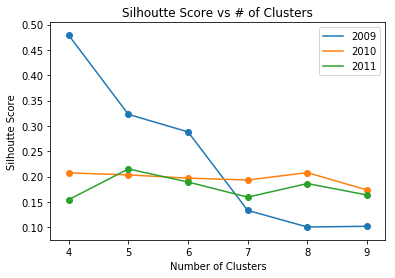

In [16]:
#Running K-Means algorithm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#We run the algorithm to pick between 4-9 clusters
cluster_range = [4,5,6,7,8,9]

#For 2009
km_array_09 = []
slh_09 = []
i=0
print(color.BOLD +color.UNDERLINE +"For 2009:\n" + color.END)
for x in cluster_range:
    #print(x)
    km_array_09.append( KMeans(n_clusters = x, random_state = 3).fit(km_09))
    slh_avg_09 = silhouette_score(km_09, km_array_09[i].fit_predict(km_09))
    slh_09.append(slh_avg_09)
    print(color.BOLD + "For", color.GREEN + str( x ) + color.END + color.BOLD +" clusters, The average silhouette_score is:"+ color.GREEN + " " + str(slh_avg_09) + color.END)
    #slh.append()
    i+=1

  
plt.plot(cluster_range, slh_09, label = slh_09)
plt.scatter(cluster_range, slh_09, label = slh_09)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score vs # of Clusters (2009 Survey)')

##########################################################################
#For 2010
km_array_10 = []
slh_10 = []
i=0
print(color.BOLD +color.UNDERLINE +"\nFor 2010:\n" + color.END)
for x in cluster_range:
    #print(x)
    km_array_10.append( KMeans(n_clusters = x, random_state = 3).fit(km_10))
    slh_avg_10 = silhouette_score(km_10, km_array_10[i].fit_predict(km_10))
    slh_10.append(slh_avg_10)
    print(color.BOLD + "For", color.GREEN + str( x ) + color.END + color.BOLD +" clusters, The average silhouette_score is:"+ color.GREEN + " " + str(slh_avg_10) + color.END)
    #slh.append()
    i+=1

  
plt.plot(cluster_range, slh_10, label = slh_10)
plt.scatter(cluster_range, slh_10, label = slh_10)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score vs # of Clusters (2010 Survey)')

##########################################################################
#For 2011
km_array_11 = []
slh_11 = []
i=0
print(color.BOLD +color.UNDERLINE +"\nFor 2011:\n" + color.END)
for x in cluster_range:
    #print(x)
    km_array_11.append( KMeans(n_clusters = x, random_state = 3).fit(km_11))
    slh_avg_11 = silhouette_score(km_11, km_array_11[i].fit_predict(km_11))
    slh_11.append(slh_avg_11)
    print(color.BOLD + "For", color.GREEN + str( x ) + color.END + color.BOLD +" clusters, The average silhouette_score is:"+ color.GREEN + " " + str(slh_avg_11) + color.END)
    #slh.append()
    i+=1

  
plt.plot(cluster_range, slh_11, label = slh_11)
plt.scatter(cluster_range, slh_11, label = slh_11)
plt.legend(loc = 'best', labels = [2009,2010,2011])
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score vs # of Clusters')

The blue, orange and green lines represent data for 2009, 2010 and 2011, respectively. 

We can see that the 2009 market segments differ significantly from the 2010 and 2011 markets, for which differences between the K-means clusters are not very significant

Based on the graph above, we segment the 2009 market in 4 clusters, the 2010 market in 8 clusters and the 2011 market in 5 clusters

In [17]:
#Storing the device names for each cluster in a dataframe

#2009
cluster_map_09 = pd.DataFrame()
cluster_map_09['Device'] = km_09.index.values
cluster_map_09['Cluster'] = km_array_09[0].labels_ +1

#Printing the devices in each cluster for 2009
print(color.BOLD +"\nFor 2009:\n" + color.END)
for x in range(1,5):
    print(color.BOLD+ color.UNDERLINE + "Devices in cluster", str(x)+ ":" + color.END)
    for i in range(0, len(cluster_map_09[cluster_map_09.Cluster == x])):
        print(color.BOLD+ colors[x-1] +  str(cluster_map_09[cluster_map_09.Cluster == x].iloc[i,0]) + color.END)
    print("\n")   

    
#############################################################    
#2010
cluster_map_10 = pd.DataFrame()
cluster_map_10['Device'] = km_10.index.values
cluster_map_10['Cluster'] = km_array_10[4].labels_ +1

#Printing the devices in each cluster for 2010
print(color.BOLD  +"\nFor 2010:\n" + color.END)
for x in range(1,9):
    print(color.BOLD+ color.UNDERLINE + "Devices in cluster", str(x)+ ":" + color.END)
    for i in range(0, len(cluster_map_10[cluster_map_10.Cluster == x])):
        print(color.BOLD+ colors[x-1] +  str(cluster_map_10[cluster_map_10.Cluster == x].iloc[i,0]) + color.END)
    print("\n")   

#############################################################    
#2011
cluster_map_11 = pd.DataFrame()
cluster_map_11['Device'] = km_11.index.values
cluster_map_11['Cluster'] = km_array_11[1].labels_ +1

#Printing the devices in each cluster for 2010
print(color.BOLD  +"\nFor 2011:\n" + color.END)
for x in range(1,6):
    print(color.BOLD+ color.UNDERLINE + "Devices in cluster", str(x)+ ":" + color.END)
    for i in range(0, len(cluster_map_11[cluster_map_11.Cluster == x])):
        print(color.BOLD+ colors[x-1] +  str(cluster_map_11[cluster_map_11.Cluster == x].iloc[i,0]) + color.END)
    print("\n")     


For 2009:

Devices in cluster 1:
Basic Phone
Blu-Ray
DVR
Desktop
E-book Reader
Fitness Band
Flat Screen TV
Gaming Console
Laptop
Portable Video Game Player
Set Top Box
Smartphone
Streaming Fob
Tablet


Devices in cluster 2:
3D Printer


Devices in cluster 3:
Smart Glasses


Devices in cluster 4:
Smart Watch



For 2010:

Devices in cluster 1:
Blu-Ray
DVR
Desktop
E-book Reader
Flat Screen TV
Laptop
Smartphone
Tablet


Devices in cluster 2:
VR Headset


Devices in cluster 3:
Smart Watch


Devices in cluster 4:
Drone


Devices in cluster 5:
Set Top Box
Streaming Fob


Devices in cluster 6:
Basic Phone


Devices in cluster 7:
Gaming Console
Portable Video Game Player


Devices in cluster 8:
Fitness Band



For 2011:

Devices in cluster 1:
Basic Phone
Blu-Ray
DVR
Desktop
E-book Reader
Flat Screen TV
Laptop
Smartphone
Tablet


Devices in cluster 2:
Smart Watch


Devices in cluster 3:
Fitness Band
Gaming Console
Portable Video Game Player
Set Top Box
Streaming Fob


Devices in cluster 4:
VR 

Based on that analysis we see that everyday objects are usually sold together, while more specific products with more specialized usages are sold separately (smart glasses/vr headsets/3d printers/drones/). Based on the anaysis it soes make sense that gaming products are usually owned by similar custmers. 

#### 6. Analyzing Clusters
We now want to explore what types of customers mostly purchase each type of product to see who our target group could be.

In [18]:
#Create a new dataframe for analyzing clusters. This dataframe includes features such as Gender, Age_Range, Region and Income_Range

#2009

current_ownership_cluster_analysis_09 = current_ownership_pivot_09.iloc[:,0:4]
#Combine cluster centroids with Devices for feature inspection
km_centers_09 = pd.DataFrame(km_array_09[0].cluster_centers_.T)
km_centers_09.columns = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4' ]
current_ownership_cluster_analysis_09 = pd.concat([current_ownership_cluster_analysis_09, km_centers_09], axis = 1)
current_ownership_cluster_analysis_09.head()

#############################################################
#2010

current_ownership_cluster_analysis_10 = current_ownership_pivot_10.iloc[:,0:4]
#Combine cluster centroids with Devices for feature inspection
km_centers_10 = pd.DataFrame(km_array_10[1].cluster_centers_.T)
km_centers_10.columns = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5' ]
current_ownership_cluster_analysis_10 = pd.concat([current_ownership_cluster_analysis_10, km_centers_10], axis = 1)
current_ownership_cluster_analysis_10.head()

#############################################################
#2011

current_ownership_cluster_analysis_11 = current_ownership_pivot_11.iloc[:,0:4]
#Combine cluster centroids with Devices for feature inspection
km_centers_11 = pd.DataFrame(km_array_11[4].cluster_centers_.T)
km_centers_11.columns = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8' ]
current_ownership_cluster_analysis_11 = pd.concat([current_ownership_cluster_analysis_11, km_centers_11], axis = 1)
current_ownership_cluster_analysis_11.head()

,Gender,Age_Range,Region,Income_Range,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
0,Female,14-19,Midwest,"100,000-299,999",0.002994,0.002744,0.003636,0.006897,0.004904,0.000000,0.000000,0.005464
1,Female,14-19,Midwest,"30,000-49,999",0.002994,0.001106,0.000000,0.000000,0.000543,0.000000,0.000000,0.002732
2,Female,14-19,Midwest,"50,000-99,999",0.005988,0.004787,0.000000,0.006897,0.008716,0.000000,0.005848,0.010929
3,Female,14-19,Midwest,Do not know,0.002994,0.004508,0.007273,0.006897,0.007630,0.011299,0.001949,0.005464
4,Female,14-19,Midwest,"Less than 29,999",0.002994,0.003538,0.000000,0.006897,0.004355,0.005650,0.000000,0.000000


#### Cluster Analysis for 2009
###### Cluster 1
General, everyday household objects.

In [19]:
current_ownership_cluster_analysis_09.sort_values('Cluster 1', ascending = False).iloc[:10,:5]

,Gender,Age_Range,Region,Income_Range,Cluster 1
156,Male,30-46,South,"100,000-299,999",0.015274
158,Male,30-46,South,"50,000-99,999",0.014889
117,Male,14-23,South,Do not know,0.013574
153,Male,30-46,Northeast,"50,000-99,999",0.013244
15,Female,14-23,South,"Less than 29,999",0.012903
36,Female,24-29,South,"Less than 29,999",0.012595
14,Female,14-23,South,Do not know,0.012399
107,Male,14-23,Midwest,Do not know,0.012011
34,Female,24-29,South,"50,000-99,999",0.011740
179,Male,47-65,South,"50,000-99,999",0.011643


This cluster seems to have a wide range of customers, without a distinguishable pattern.

##### Cluster 2
3D printers

In [20]:
current_ownership_cluster_analysis_09.sort_values('Cluster 2', ascending = False).iloc[:10,:6]

,Gender,Age_Range,Region,Income_Range,Cluster 1,Cluster 2
136,Male,24-29,South,"30,000-49,999",0.011136,0.073171
127,Male,24-29,Midwest,"50,000-99,999",0.007217,0.048780
27,Female,24-29,Northeast,"100,000-299,999",0.006580,0.048780
140,Male,24-29,West,"100,000-299,999",0.005820,0.048780
139,Male,24-29,South,"Less than 29,999",0.009762,0.048780
34,Female,24-29,South,"50,000-99,999",0.011740,0.048780
158,Male,30-46,South,"50,000-99,999",0.014889,0.048780
142,Male,24-29,West,"50,000-99,999",0.009495,0.048780
116,Male,14-23,South,"50,000-99,999",0.010313,0.024390
130,Male,24-29,Northeast,"100,000-299,999",0.007587,0.024390


We can see that the main customer group interested in 3D printers are young males of mid-range income.

##### Cluster 3
Smart glasses

In [21]:
current_ownership_cluster_analysis_09.sort_values('Cluster 3', ascending = False).iloc[:10,:7]

,Gender,Age_Range,Region,Income_Range,Cluster 1,Cluster 2,Cluster 3
127,Male,24-29,Midwest,"50,000-99,999",0.007217,0.04878,0.100000
158,Male,30-46,South,"50,000-99,999",0.014889,0.04878,0.066667
140,Male,24-29,West,"100,000-299,999",0.005820,0.04878,0.066667
108,Male,14-23,Midwest,"Less than 29,999",0.008789,0.02439,0.066667
156,Male,30-46,South,"100,000-299,999",0.015274,0.02439,0.033333
161,Male,30-46,West,"100,000-299,999",0.008660,0.00000,0.033333
163,Male,30-46,West,"50,000-99,999",0.010806,0.02439,0.033333
166,Male,47-65,Midwest,"100,000-299,999",0.008353,0.00000,0.033333
41,Female,24-29,West,"Less than 29,999",0.005150,0.02439,0.033333
71,Female,47-65,Northeast,"Less than 29,999",0.002041,0.00000,0.033333


In contrast to 3D printers cluster, the main group interested in smart glasses are mid-age males with a higher level of income.

##### Cluster 4
Smart Watch

In [22]:
current_ownership_cluster_analysis_09.sort_values('Cluster 4', ascending = False).iloc[:10,:8]

,Gender,Age_Range,Region,Income_Range,Cluster 1,Cluster 2,Cluster 3,Cluster 4
136,Male,24-29,South,"30,000-49,999",0.011136,0.073171,0.033333,0.078431
185,Male,47-65,West,"50,000-99,999",0.006690,0.000000,0.000000,0.039216
156,Male,30-46,South,"100,000-299,999",0.015274,0.024390,0.033333,0.039216
32,Female,24-29,South,"100,000-299,999",0.004961,0.000000,0.000000,0.039216
108,Male,14-23,Midwest,"Less than 29,999",0.008789,0.024390,0.066667,0.039216
116,Male,14-23,South,"50,000-99,999",0.010313,0.024390,0.033333,0.039216
118,Male,14-23,South,"Less than 29,999",0.011064,0.024390,0.033333,0.039216
127,Male,24-29,Midwest,"50,000-99,999",0.007217,0.048780,0.100000,0.039216
140,Male,24-29,West,"100,000-299,999",0.005820,0.048780,0.066667,0.019608
34,Female,24-29,South,"50,000-99,999",0.011740,0.048780,0.000000,0.019608


This cluster focuses mostly consists of very young males with lower to mid range income (millenials?)

### 3. Customer Analysis: Smartphone app usage analysis
Now we move on to see what kind of analysis we can draw from the smartphone usage information

In [23]:
#Subset questions on mobile/tablet app usage

#2009
app_usage_09 = survey_09.iloc[:,97:125]
colnames_09 = ['Photo/Video','Banking','Fitness/Health', 'Food/Drink','Retail', 'Navigation', 'Social Media','Books', 'Streaming Music', 
                  'Streaming Video', 'Reviews', 'News Aggregator', 'Newspaper', 'Magazine','Utilities','QR Reader',
               'Travel', 'Transportation', 'Location', 'Language', 'Movie', 'Business', 'Games', 'Productivity', 'Sports',
              'Weather', 'Browser', 'VOIP']

app_usage_09.columns = colnames_09


#2010
app_usage_10 = survey_10.iloc[:,91:126]
colnames_10 = ['Photo/Video','Banking','Fitness/Health', 'Food/Drink','Retail', 'Navigation', 'Social Media','Books', 
               'Streaming Music','Streaming Video', 'Reviews', 'News Aggregator', 'Newspaper', 'Magazine','Utilities',
               'QR Reader','Travel', 'Transportation', 'Location', 'Language', 'Movie', 'Business', 'Games',
               'Productivity', 'Sports','Weather', 'Browser', 'VOIP', 'Dating', 'Messaging', 'Mobile Payment', 
               'Education', 'Ticketes', 'Reservations', 'Hobbies']

app_usage_10.columns = colnames_10


#2011
app_usage_11 = survey_11.iloc[:,91:126]
colnames_11 = ['Photo/Video','Banking','Fitness/Health', 'Food/Drink','Retail', 'Navigation', 'Social Media','Books', 
               'Streaming Music','Streaming Video', 'Reviews', 'News Aggregator', 'Newspaper', 'Magazine','Utilities',
               'QR Reader','Travel', 'Transportation', 'Location', 'Language', 'Movie', 'Business', 'Games',
               'Productivity', 'Sports','Weather', 'Browser', 'VOIP', 'Dating', 'Messaging', 'Mobile Payment', 
               'Education', 'Ticketes', 'Reservations', 'Hobbies']

app_usage_11.columns = colnames_11

print(len(app_usage_09.columns))
print(len(app_usage_10.columns))
print(len(app_usage_11.columns))

#print(app_usage_09.shape)
#print(app_usage_10.shape)
#print(app_usage_11.shape)

28
35
35


In [24]:
#### Convert Yes/No responses to numerical data for getting summary counts

#for 2009
for x in range(0, 28):
    app_usage_09.iloc[:,x] = app_usage_09.iloc[:,x].map({'Yes':1, 'No':0, 'NaN':0})

#for 2010
for x in range(0, 35):
    app_usage_10.iloc[:,x] = app_usage_10.iloc[:,x].map({'Yes':1, 'No':0})
         
    
#for 2011
for x in range(0, 35):
    app_usage_11.iloc[:,x] = app_usage_11.iloc[:,x].map({'Yes':1, 'No':0})


app_usage_09.fillna(0, inplace = True)
app_usage_10.fillna(0, inplace = True)    
app_usage_11.fillna(0, inplace = True)    

### Combine Demographic and App Usage data
#### 1. Merge app usage with demographics

In [25]:
#2009
app_usage_09 = pd.concat([demographics_09, app_usage_09], axis = 1)
print(app_usage_09.shape)

#2010
app_usage_10 = pd.concat([demographics_10, app_usage_10], axis = 1)
print(app_usage_10.shape)

#2011
app_usage_11 = pd.concat([demographics_11, app_usage_11], axis = 1)
print(app_usage_11.shape)

(2076, 37)
(2205, 44)
(2131, 44)


In [26]:
app_usage_10.head()

,Age,Gender,Age_Range,State,Region,Emp_Status,Ethnicity,Has_Children,Income_Range,Photo/Video,...,Weather,Browser,VOIP,Dating,Messaging,Mobile Payment,Education,Ticketes,Reservations,Hobbies
0,31,Female,30-46,Illinois,Midwest,Unemployed,White or Caucasian (Non-Hispanic),Yes,"50,000-99,999",0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,30,Female,30-46,Arkansas,South,Unemployed,White or Caucasian (Non-Hispanic),Yes,"30,000-49,999",1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,61,Male,47-65,Alabama,South,Retired,White or Caucasian (Non-Hispanic),No,"100,000-299,999",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,68,Female,66 or older,New York,Northeast,Retired,White or Caucasian (Non-Hispanic),No,"50,000-99,999",1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50,Female,47-65,Iowa,Midwest,Employed full-time or part-time,White or Caucasian (Non-Hispanic),No,"50,000-99,999",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2. Reshape the dataset to record the count of each app

In [27]:
#2009
app_usage_09 = pd.melt(pd.DataFrame(app_usage_09.iloc[:,:]), 
                                  id_vars = [ 'Age', 'Gender', 'Age_Range', 'State', 'Region', 'Emp_Status', 'Ethnicity', 'Has_Children', 'Income_Range'],
                                  var_name = 'App Category', value_name = 'Quantity' )

print(app_usage_09.shape)

#2010
app_usage_10 = pd.melt(pd.DataFrame(app_usage_10.iloc[:,:]), 
                                  id_vars = [ 'Age', 'Gender', 'Age_Range', 'State', 'Region', 'Emp_Status', 'Ethnicity', 'Has_Children', 'Income_Range'],
                                  var_name = 'App Category', value_name = 'Quantity' )

print(app_usage_10.shape)

#2011
app_usage_11 = pd.melt(pd.DataFrame(app_usage_11.iloc[:,:]), 
                                  id_vars = [ 'Age', 'Gender', 'Age_Range', 'State', 'Region', 'Emp_Status', 'Ethnicity', 'Has_Children', 'Income_Range'],
                                  var_name = 'App Category', value_name = 'Quantity' )

print(app_usage_11.shape)


(58128, 11)
(77175, 11)
(74585, 11)


#### 3. Group Apps by demographic indicators

In [28]:
#Groupby for 2009

app_usage_groupby_09 = app_usage_09.groupby(['App Category','Gender', 'Age_Range','Has_Children','Income_Range'
                                                               ], as_index = False)['Quantity'].sum()
print(app_usage_groupby_09.shape)
app_usage_groupby_09.head()

#Groupby for 2010

app_usage_groupby_10 = app_usage_10.groupby(['App Category','Gender', 'Age_Range','Has_Children','Income_Range'
                                                               ], as_index = False)['Quantity'].sum()
print(app_usage_groupby_10.shape)
app_usage_groupby_10.head()

#Groupby for 2011

app_usage_groupby_11 = app_usage_11.groupby(['App Category','Gender', 'Age_Range','Has_Children','Income_Range'
                                                               ], as_index = False)['Quantity'].sum()
print(app_usage_groupby_11.shape)
app_usage_groupby_11.head()


(3052, 6)
(3640, 6)
(4410, 6)


,App Category,Gender,Age_Range,Has_Children,Income_Range,Quantity
0,Banking,Female,14-19,No,"100,000-299,999",3.0
1,Banking,Female,14-19,No,"30,000-49,999",6.0
2,Banking,Female,14-19,No,"50,000-99,999",7.0
3,Banking,Female,14-19,No,Do not know,2.0
4,Banking,Female,14-19,No,"Less than 29,999",3.0


#### 4. Create pivot table on App Categories

In [29]:
#2009 pivot table
app_usage_pivot_09 = app_usage_groupby_09.pivot_table(index = ['Gender', 'Age_Range', 'Has_Children', 'Income_Range'
                                                                              ], columns = 'App Category', values = 'Quantity')
#Convert NA values to 0
app_usage_pivot_09.fillna(0, inplace = True)
#Reset Index
app_usage_pivot_09.reset_index(inplace = True)
print( "Dimensions of 2009 pivot table are: " +  str(app_usage_pivot_09.shape))

#2010 pivot table
app_usage_pivot_10 = app_usage_groupby_10.pivot_table(index = ['Gender', 'Age_Range', 'Has_Children', 'Income_Range'
                                                                              ], columns = 'App Category', values = 'Quantity')
#Convert NA values to 0
app_usage_pivot_10.fillna(0, inplace = True)
#Reset Index
app_usage_pivot_10.reset_index(inplace = True)
print( "Dimensions of 2010 pivot table are: " +  str(app_usage_pivot_10.shape))

#2011 pivot table
app_usage_pivot_11 = app_usage_groupby_11.pivot_table(index = ['Gender', 'Age_Range', 'Has_Children', 'Income_Range'
                                                                              ], columns = 'App Category', values = 'Quantity')
#Convert NA values to 0
app_usage_pivot_11.fillna(0, inplace = True)
#Reset Index
app_usage_pivot_11.reset_index(inplace = True)
print( "Dimensions of 2011 pivot table are: " +  str(app_usage_pivot_11.shape))


#Scaling
#2009
for i in range(4, 32):
    app_usage_pivot_09.iloc[:,i] = app_usage_pivot_09.iloc[:,i]/(app_usage_pivot_09.iloc[:,i].sum())
   
#2010 and 2011
for i in range(4, 39):
    app_usage_pivot_10.iloc[:,i] = app_usage_pivot_10.iloc[:,i]/(app_usage_pivot_10.iloc[:,i].sum())
    app_usage_pivot_11.iloc[:,i] = app_usage_pivot_11.iloc[:,i]/(app_usage_pivot_11.iloc[:,i].sum())

Dimensions of 2009 pivot table are: (109, 32)
Dimensions of 2010 pivot table are: (104, 39)
Dimensions of 2011 pivot table are: (126, 39)


#### 5. Use k-means to identify different clusters based on app categories

In [30]:
#Remove unwanted columns and create a new dataframe for k-means clustering

#2009
km_app_09 = app_usage_pivot_09.iloc[:,4:].T

#2010
km_app_10 = app_usage_pivot_10.iloc[:,4:].T

#2011
km_app_11 = app_usage_pivot_11.iloc[:,4:].T

km_app_09.head()
#km_app_10.head()
#km_app_11.head()

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
App Category,,,,,,,,,,,,,,,,,,,,,
Banking,0.005367,0.016100,0.019678,0.007156,0.026834,0.001789,0.007156,0.001789,0.007156,0.007156,...,0.016100,0.008945,0.017889,0.0,0.000000,0.0,0.0,0.000000,0.001789,0.0
Books,0.002967,0.011869,0.011869,0.017804,0.017804,0.000000,0.005935,0.014837,0.005935,0.017804,...,0.014837,0.005935,0.023739,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
Browser,0.004127,0.015131,0.017882,0.019257,0.031637,0.000000,0.009629,0.005502,0.015131,0.020633,...,0.006878,0.006878,0.023384,0.0,0.001376,0.0,0.0,0.001376,0.001376,0.0
Business,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,...,0.036364,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
Fitness/Health,0.012245,0.024490,0.032653,0.024490,0.036735,0.004082,0.004082,0.004082,0.016327,0.036735,...,0.000000,0.000000,0.004082,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


For 2009:

For 4 clusters, The average silhouette_score is: 0.1574242339487732
For 5 clusters, The average silhouette_score is: 0.15532477450338036
For 6 clusters, The average silhouette_score is: 0.15803171137911812
For 7 clusters, The average silhouette_score is: 0.15444291182809766
For 8 clusters, The average silhouette_score is: 0.1334075457891312
For 9 clusters, The average silhouette_score is: 0.052435867572035576

For 2010:

For 4 clusters, The average silhouette_score is: 0.11121181130727588
For 5 clusters, The average silhouette_score is: 0.11738898959555494
For 6 clusters, The average silhouette_score is: 0.08572309186380091
For 7 clusters, The average silhouette_score is: 0.10543924822067767
For 8 clusters, The average silhouette_score is: 0.09544057420893294
For 9 clusters, The average silhouette_score is: 0.10124312545553127

For 2011:

For 4 clusters, The average silhouette_score is: 0.08972160533548577
For 5 clusters, The average silhouette_score is: 0.1697931322860342
F

Text(0.5,1,'Silhoutte Score vs # of Clusters')

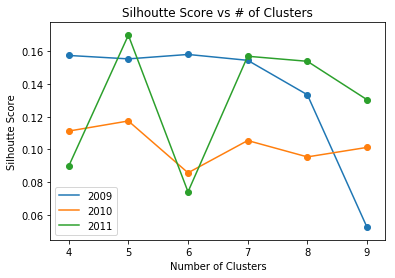

In [31]:
#Run k-means algorithm

#We run the algorithm to pick between 4-9 clusters
cluster_range = [4,5,6,7,8,9]#,10,11,12,13,14,15,16,17]

#For 2009
km_app_array_09 = []
slh_app_09 = []
i=0
print(color.BOLD +color.UNDERLINE +"For 2009:\n" + color.END)
for x in cluster_range:
    #print(x)
    km_app_array_09.append( KMeans(n_clusters = x, random_state = 12).fit(km_app_09))
    slh_app_avg_09 = silhouette_score(km_app_09, km_app_array_09[i].fit_predict(km_app_09))
    slh_app_09.append(slh_app_avg_09)
    print(color.BOLD + "For", color.GREEN + str( x ) + color.END + color.BOLD +" clusters, The average silhouette_score is:"+ color.GREEN + " " + str(slh_app_avg_09) + color.END)
    #slh.append()
    i+=1

  
plt.plot(cluster_range, slh_app_09, label = slh_app_09)
plt.scatter(cluster_range, slh_app_09, label = slh_app_09)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score vs # of Clusters (2009 Survey)')

##########################################################################
#For 2010
km_app_array_10 = []
slh_app_10 = []
i=0
print(color.BOLD +color.UNDERLINE +"\nFor 2010:\n" + color.END)
for x in cluster_range:
    #print(x)
    km_app_array_10.append( KMeans(n_clusters = x, random_state = 12).fit(km_app_10))
    slh_app_avg_10 = silhouette_score(km_app_10, km_app_array_10[i].fit_predict(km_app_10))
    slh_app_10.append(slh_app_avg_10)
    print(color.BOLD + "For", color.GREEN + str( x ) + color.END + color.BOLD +" clusters, The average silhouette_score is:"+ color.GREEN + " " + str(slh_app_avg_10) + color.END)
    #slh.append()
    i+=1

  
plt.plot(cluster_range, slh_app_10, label = slh_app_10)
plt.scatter(cluster_range, slh_app_10, label = slh_app_10)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score vs # of Clusters (2010 Survey)')

##########################################################################
#For 2011
km_app_array_11 = []
slh_app_11 = []
i=0
print(color.BOLD +color.UNDERLINE +"\nFor 2011:\n" + color.END)
for x in cluster_range:
    #print(x)
    km_app_array_11.append( KMeans(n_clusters = x, random_state = 12).fit(km_app_11))
    slh_app_avg_11 = silhouette_score(km_app_11, km_app_array_11[i].fit_predict(km_app_11))
    slh_app_11.append(slh_app_avg_11)
    print(color.BOLD + "For", color.GREEN + str( x ) + color.END + color.BOLD +" clusters, The average silhouette_score is:"+ color.GREEN + " " + str(slh_app_avg_11) + color.END)
    #slh.append()
    i+=1

  
plt.plot(cluster_range, slh_app_11, label = slh_app_11)
plt.scatter(cluster_range, slh_app_11, label = slh_app_11)
plt.legend(loc = 'best', labels = [2009,2010,2011])
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score vs # of Clusters')

Based on the plot and silhouette scores above, we see that for 2009 the market can be segmented into 6 clusters, and both 2010 and 2011 markets into 5 clusters

In [32]:
#Storing the app categories for each cluster in a dataframe

#2009
app_cluster_map_09 = pd.DataFrame()
app_cluster_map_09['Device'] = km_app_09.index.values
app_cluster_map_09['Cluster'] = km_app_array_09[2].labels_ +1

#Printing the devices in each cluster for 2009
print(color.BOLD +"\nFor 2009:\n" + color.END)
for x in range(1,7):
    print(color.BOLD+ color.UNDERLINE + "Devices in cluster", str(x)+ ":" + color.END)
    for i in range(0, len(app_cluster_map_09[app_cluster_map_09.Cluster == x])):
        print(color.BOLD+ colors[x-1] +  str(app_cluster_map_09[app_cluster_map_09.Cluster == x].iloc[i,0]) + color.END)
    print("\n")   

    
#############################################################    
#2010
app_cluster_map_10 = pd.DataFrame()
app_cluster_map_10['Device'] = km_app_10.index.values
app_cluster_map_10['Cluster'] = km_app_array_10[1].labels_ +1

#Printing the devices in each cluster for 2010
print(color.BOLD  +"\nFor 2010:\n" + color.END)
for x in range(1,6):
    print(color.BOLD+ color.UNDERLINE + "Devices in cluster", str(x)+ ":" + color.END)
    for i in range(0, len(app_cluster_map_10[app_cluster_map_10.Cluster == x])):
        print(color.BOLD+ colors[x-1] +  str(app_cluster_map_10[app_cluster_map_10.Cluster == x].iloc[i,0]) + color.END)
    print("\n")   

#############################################################    
#2011
app_cluster_map_11 = pd.DataFrame()
app_cluster_map_11['Device'] = km_app_11.index.values
app_cluster_map_11['Cluster'] = km_app_array_11[1].labels_ +1

#Printing the devices in each cluster for 2010
print(color.BOLD  +"\nFor 2011:\n" + color.END)
for x in range(1,6):
    print(color.BOLD+ color.UNDERLINE + "Devices in cluster", str(x)+ ":" + color.END)
    for i in range(0, len(app_cluster_map_11[app_cluster_map_11.Cluster == x])):
        print(color.BOLD+ colors[x-1] +  str(app_cluster_map_11[app_cluster_map_11.Cluster == x].iloc[i,0]) + color.END)
    print("\n")     


For 2009:

Devices in cluster 1:
Books
Browser
Fitness/Health
Food/Drink
Games
Language
Movie
Photo/Video
Productivity
Retail
Social Media
Streaming Music
Streaming Video


Devices in cluster 2:
Business
Sports


Devices in cluster 3:
VOIP


Devices in cluster 4:
QR Reader


Devices in cluster 5:
Magazine


Devices in cluster 6:
Banking
Location
Navigation
News Aggregator
Newspaper
Reviews
Transportation
Travel
Utilities
Weather



For 2010:

Devices in cluster 1:
Business
Magazine
News Aggregator
Sports
Ticketes
Utilities


Devices in cluster 2:
Books
Browser
Dating
Education
Fitness/Health
Food/Drink
Games
Hobbies
Language
Messaging
Mobile Payment
Movie
Photo/Video
Retail
Social Media
Streaming Music
Streaming Video


Devices in cluster 3:
Banking
Location
Navigation
Newspaper
Productivity
Reservations
Reviews
Transportation
Travel
Weather


Devices in cluster 4:
VOIP


Devices in cluster 5:
QR Reader



For 2011:

Devices in cluster 1:
Banking
Books
Browser
Games
Hobbies
Location
M

It is interesting to notice that business applications very often are used by the people who use sport. Additionally travel app users also use reservation apps. Moreover, there tend to be two different clusters of users, one focusing on general, everyday casual apps, and the other focusing on more professional applications.

#### 6. Analyzing Clusters

In [33]:
#Create a new dataframe for analyzing clusters. This dataframe includes features such as Gender, Age_Range, Has_Children and Income_Range

#2009

app_usage_cluster_analysis_09 = app_usage_pivot_09.iloc[:,0:4]
#Combine cluster centroids with Devices for feature inspection
app_km_centers_09 = pd.DataFrame(km_app_array_09[2].cluster_centers_.T)
app_km_centers_09.columns = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6' ]
app_usage_cluster_analysis_09 = pd.concat([app_usage_cluster_analysis_09, app_km_centers_09], axis = 1)
app_usage_cluster_analysis_09.head()

#############################################################
#2010

app_usage_cluster_analysis_10 = app_usage_pivot_10.iloc[:,0:4]
#Combine cluster centroids with Devices for feature inspection
app_km_centers_10 = pd.DataFrame(km_app_array_10[1].cluster_centers_.T)
app_km_centers_10.columns = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5' ]
app_usage_cluster_analysis_10 = pd.concat([app_usage_cluster_analysis_10, app_km_centers_10], axis = 1)
app_usage_cluster_analysis_10.head()

#############################################################
#2011

app_usage_cluster_analysis_11 = app_usage_pivot_11.iloc[:,0:4]
#Combine cluster centroids with Devices for feature inspection
app_km_centers_11 = pd.DataFrame(km_app_array_11[1].cluster_centers_.T)
app_km_centers_11.columns = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5']
app_usage_cluster_analysis_11 = pd.concat([app_usage_cluster_analysis_11, app_km_centers_11], axis = 1)
app_usage_cluster_analysis_11.head()

,Gender,Age_Range,Has_Children,Income_Range,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,Female,14-19,No,"100,000-299,999",0.007833,0.000000,0.002688,0.008879,0.006513
1,Female,14-19,No,"30,000-49,999",0.016713,0.000000,0.000000,0.013721,0.000000
2,Female,14-19,No,"50,000-99,999",0.012808,0.004032,0.000000,0.011032,0.000000
3,Female,14-19,No,Do not know,0.012038,0.000000,0.000000,0.005837,0.000000
4,Female,14-19,No,"Less than 29,999",0.009251,0.000000,0.000000,0.008291,0.002545


#### Cluster Analysis for 2009
##### Cluster 1
The "casual apps" cluster

In [34]:
app_usage_cluster_analysis_09.sort_values('Cluster 1', ascending = False).iloc[:10,:4]

,Gender,Age_Range,Has_Children,Income_Range
4,Female,14-23,No,"Less than 29,999"
58,Male,14-23,No,"Less than 29,999"
14,Female,24-29,No,"50,000-99,999"
81,Male,30-46,Yes,"100,000-299,999"
67,Male,24-29,No,"50,000-99,999"
83,Male,30-46,Yes,"50,000-99,999"
25,Female,30-46,No,"50,000-99,999"
3,Female,14-23,No,Do not know
9,Female,14-23,Yes,Do not know
22,Female,24-29,Yes,"Less than 29,999"


Following our expectations, this cluster consists of a very varied group of mostly young people with lower incomes.

##### Cluster 2
Business and Sports Apps

In [35]:
app_usage_cluster_analysis_09.sort_values('Cluster 2', ascending = False).iloc[:10,:4]

,Gender,Age_Range,Has_Children,Income_Range
81,Male,30-46,Yes,"100,000-299,999"
58,Male,14-23,No,"Less than 29,999"
83,Male,30-46,Yes,"50,000-99,999"
67,Male,24-29,No,"50,000-99,999"
93,Male,47-65,Yes,"100,000-299,999"
55,Male,14-23,No,"30,000-49,999"
71,Male,24-29,Yes,"30,000-49,999"
87,Male,47-65,No,"100,000-299,999"
62,Male,14-23,Yes,"50,000-99,999"
99,Male,66 or older,No,"100,000-299,999"


This cluster very clearly includes predominantly male groups of all ages and incomes

##### Cluster 3
VOIP Apps

In [36]:
app_usage_cluster_analysis_09.sort_values('Cluster 3', ascending = False).iloc[:10,:4]

,Gender,Age_Range,Has_Children,Income_Range
81,Male,30-46,Yes,"100,000-299,999"
83,Male,30-46,Yes,"50,000-99,999"
69,Male,24-29,No,"Less than 29,999"
82,Male,30-46,Yes,"30,000-49,999"
93,Male,47-65,Yes,"100,000-299,999"
2,Female,14-23,No,"50,000-99,999"
40,Female,47-65,Yes,"30,000-49,999"
13,Female,24-29,No,"30,000-49,999"
20,Female,24-29,Yes,"50,000-99,999"
19,Female,24-29,Yes,"30,000-49,999"


This cluster exhibits a good balance of mostly middle age, middle income users.

##### Cluster 4
QR Reader

In [37]:
app_usage_cluster_analysis_09.sort_values('Cluster 4', ascending = False).iloc[:10,:4]

,Gender,Age_Range,Has_Children,Income_Range
69,Male,24-29,No,"Less than 29,999"
81,Male,30-46,Yes,"100,000-299,999"
83,Male,30-46,Yes,"50,000-99,999"
57,Male,14-23,No,Do not know
67,Male,24-29,No,"50,000-99,999"
93,Male,47-65,Yes,"100,000-299,999"
55,Male,14-23,No,"30,000-49,999"
89,Male,47-65,No,"50,000-99,999"
77,Male,30-46,No,"50,000-99,999"
20,Female,24-29,Yes,"50,000-99,999"


This group very clearly focuses on male users of all ages and incomes. 

##### Cluster 5
Magazine

In [38]:
app_usage_cluster_analysis_09.sort_values('Cluster 5', ascending = False).iloc[:10,:4]

,Gender,Age_Range,Has_Children,Income_Range
81,Male,30-46,Yes,"100,000-299,999"
93,Male,47-65,Yes,"100,000-299,999"
25,Female,30-46,No,"50,000-99,999"
72,Male,24-29,Yes,"50,000-99,999"
55,Male,14-23,No,"30,000-49,999"
19,Female,24-29,Yes,"30,000-49,999"
12,Female,24-29,No,"100,000-299,999"
56,Male,14-23,No,"50,000-99,999"
29,Female,30-46,Yes,"30,000-49,999"
22,Female,24-29,Yes,"Less than 29,999"


This cluster exhibits a relatively good distribution of predominantely young people.

##### Cluster 6
"Professional" Apps

In [39]:
app_usage_cluster_analysis_09.sort_values('Cluster 6', ascending = False).iloc[:10,:4]

,Gender,Age_Range,Has_Children,Income_Range
81,Male,30-46,Yes,"100,000-299,999"
93,Male,47-65,Yes,"100,000-299,999"
83,Male,30-46,Yes,"50,000-99,999"
77,Male,30-46,No,"50,000-99,999"
25,Female,30-46,No,"50,000-99,999"
58,Male,14-23,No,"Less than 29,999"
89,Male,47-65,No,"50,000-99,999"
14,Female,24-29,No,"50,000-99,999"
101,Male,66 or older,No,"50,000-99,999"
75,Male,30-46,No,"100,000-299,999"


Following our expectations this cluster mostly includes high-income older males without children.

### 4. Time Trend Analysis

#### Basic data cleaning for 2009

In [40]:

#---Read the dataset for 2009
DDS9_df = pd.read_excel('DDS9_Data_Extract_with_labels.xlsx')

#filter out the columns that are not necessary for the analysis (Column name is used so in case if the question order changs in future,
# the logic should work 

cols_sel = ['age - you are...',
'Q2 - In which state do you currently reside?',
'region - Region',
'QNEW3 - What is your employment status?',
'QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?',
'Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential.',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Desktop computer',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Laptop computer',           
'Q15r1 - Smartphone - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q15r2 - Tablet - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q15r3 - Laptop/Desktop - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q15r4 - Television - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q16r1 - Smartphone - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q16r2 - Tablet - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q16r3 - Laptop/Desktop - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q16r4 - Television - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q17r1 - Smartphone - Of the time you spend watching TV shows , what percentage of time do you watch on the following devices?',
'Q17r2 - Tablet - Of the time you spend watching TV shows, what percentage of time do you watch on the following devices?',
'Q17r3 - Laptop/Desktop - Of the time you spend watching TV shows , what percentage of time do you watch on the following devices?',
'Q17r4 - Television - Of the time you spend watching TV shows , what percentage of time do you watch on the following devices?',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Tablet (nine inches and above)',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Small tablet (between seven and nine inches)',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Smartphone (three to five inches)',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Large smartphone (between five and seven inches)'            
]

# define the column name for dataset
cols_name =['age','state','region','emp_status','children','annual_sal',"Streaming_media_box",'Portable_streaming_thumb_drive','Television','Desktop','laptop','smartphone_mov','tablet_mov','laptop_mov','tv_mov','smartphone_sports','tablet_sports','laptop_sports','tv_sports','smartphone_tv_shw','tablet_tv_shw','laptop_tv_shw','tv_tv_shw','Tablet1','Tablet2','SmartPhone1','SmartPhone2']

#apply filter and rename the columns
DDS9_df = DDS9_df[cols_sel]
DDS9_df.columns = cols_name
DDS9_df.head()

,age,state,region,emp_status,children,annual_sal,Streaming_media_box,Portable_streaming_thumb_drive,Television,Desktop,...,laptop_sports,tv_sports,smartphone_tv_shw,tablet_tv_shw,laptop_tv_shw,tv_tv_shw,Tablet1,Tablet2,SmartPhone1,SmartPhone2
0,24-29,California,West,Unemployed,No,"$50,000 to $99,999",No,No,No,No,...,-1,-1,0,0,100,0,Yes,No,Yes,Yes
1,30-46,New York,Northeast,Unemployed,Yes,"$50,000 to $99,999",No,No,Yes,Yes,...,2,98,0,0,1,99,No,No,No,No
2,24-29,Nevada,West,Employed full-time or part-time,No,"$50,000 to $99,999",Yes,No,Yes,Yes,...,15,85,0,0,40,60,No,No,Yes,No
3,47-65,New Jersey,Northeast,Self-employed,No,"$100,000 to $299,999",No,No,Yes,No,...,1,99,5,5,15,75,Yes,No,Yes,No
4,14-23,Arkansas,South,Unemployed,No,"Less than $29,999",No,No,Yes,No,...,-1,-1,0,0,50,50,No,No,No,Yes


#### Basic data cleaning for 2010

In [41]:
#---Read the dataset for 2010
DDS10_df = pd.read_excel('DDS10_Data_Extract_with_labels.xlsx')

list(DDS10_df.columns)


cols_sel = ['age - you are...',
'Q2 - In which state do you currently reside?',
'region - Region',
'QNEW3 - What is your employment status?',
'QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?',
'Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential.',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Desktop computer',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Laptop computer',
'Q15r1 - Smartphone - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q15r2 - Tablet - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q15r3 - Laptop/Desktop - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q15r4 - Television - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q16r1 - Smartphone - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q16r2 - Tablet - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q16r3 - Laptop/Desktop - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q16r4 - Television - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q17r1 - Smartphone - Of the time you spend watching TV shows, what percentage of time do you watch on the following devices?',
'Q17r2 - Tablet - Of the time you spend watching TV shows, what percentage of time do you watch on the following devices?',
'Q17r3 - Laptop/Desktop - Of the time you spend watching TV shows, what percentage of time do you watch on the following devices?',
'Q17r4 - Television - Of the time you spend watching TV shows, what percentage of time do you watch on the following devices?',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Tablet',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Smartphone']

#define column name
cols_name =['age','state','region','emp_status','children','annual_sal',"Streaming_media_box",'Portable_streaming_thumb_drive','Television','Desktop','laptop','smartphone_mov','tablet_mov','laptop_mov','tv_mov','smartphone_sports','tablet_sports','laptop_sports','tv_sports','smartphone_tv_shw','tablet_tv_shw','laptop_tv_shw','tv_tv_shw','Tablet','Smartphone']

# apply filter and rename the columns
DDS10_df = DDS10_df[cols_sel]
DDS10_df.columns = cols_name

DDS10_df.head()


,age,state,region,emp_status,children,annual_sal,Streaming_media_box,Portable_streaming_thumb_drive,Television,Desktop,...,smartphone_sports,tablet_sports,laptop_sports,tv_sports,smartphone_tv_shw,tablet_tv_shw,laptop_tv_shw,tv_tv_shw,Tablet,Smartphone
0,30-46,Illinois,Midwest,Unemployed,Yes,"$50,000 to $99,999",No,No,No,Yes,...,25,25,50,0,25,25,50,0,Yes,Yes
1,30-46,Arkansas,South,Unemployed,Yes,"$30,000 to $49,999",No,No,Yes,No,...,-1,-1,-1,-1,0,0,5,95,Yes,Yes
2,47-65,Alabama,South,Retired,No,"$100,000 to $299,999",No,No,Yes,Yes,...,-1,-1,-1,-1,0,0,0,100,Yes,Yes
3,66 or older,New York,Northeast,Retired,No,"$50,000 to $99,999",Yes,Yes,Yes,Yes,...,-1,-1,-1,-1,0,10,0,90,Yes,Yes
4,47-65,Iowa,Midwest,Employed full-time or part-time,No,"$50,000 to $99,999",No,No,Yes,No,...,-1,-1,-1,-1,0,0,0,100,Yes,No


#### Basic data cleaning for 2011

In [42]:
#---Read the dataset for 2011
DDS11_df = pd.read_excel('DDS11_Data_Extract_with_labels.xlsx')

cols_sel = ['age - you are...',
'Q2 - In which state do you currently reside?',
'region - Region',
'QNEW3 - What is your employment status?',
'QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?',
'Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential.',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Desktop computer',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Laptop computer',            
'Q15r1 - Smartphone - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q15r2 - Tablet - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q15r3 - Laptop/Desktop - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q15r4 - Television - Of the time you spend watching movies, what percentage of time do you watch on the following devices?',
'Q16r1 - Smartphone - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q16r2 - Tablet - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q16r3 - Laptop/Desktop - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q16r4 - Television - Of the time you spend watching sports, what percentage of time do you watch on the following devices?',
'Q17r1 - Smartphone - Of the time you spend watching TV shows , what percentage of time do you watch on the following devices?',
'Q17r2 - Tablet - Of the time you spend watching TV shows , what percentage of time do you watch on the following devices?',
'Q17r3 - Laptop/Desktop - Of the time you spend watching TV shows , what percentage of time do you watch on the following devices?',
'Q17r4 - Television - Of the time you spend watching TV shows , what percentage of time do you watch on the following devices?',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Tablet',
'Q8 - Which of the following media or home entertainment equipment does your household own?-Smartphone']

#Apply filter and rename the columns
DDS11_df = DDS11_df[cols_sel]
DDS11_df.columns = cols_name


#DDS11_df['year'] = '2011'

DDS11_df.head()



,age,state,region,emp_status,children,annual_sal,Streaming_media_box,Portable_streaming_thumb_drive,Television,Desktop,...,smartphone_sports,tablet_sports,laptop_sports,tv_sports,smartphone_tv_shw,tablet_tv_shw,laptop_tv_shw,tv_tv_shw,Tablet,Smartphone
0,34-50,Georgia,South,Employed full-time or part-time,Yes,"$50,000 to $99,999",No,No,No,No,...,0,0,100,0,0,0,100,0,No,No
1,20-26,New York,Northeast,Employed full-time or part-time,Yes,"$50,000 to $99,999",No,Yes,No,No,...,40,30,30,0,30,30,40,0,Yes,Yes
2,27-33,New Jersey,Northeast,Employed full-time or part-time,Yes,"Less than $29,999",No,No,No,No,...,0,0,100,0,0,0,100,0,No,No
3,20-26,California,West,Employed full-time or part-time,Yes,"Less than $29,999",No,Yes,Yes,No,...,10,15,0,75,0,25,0,75,Yes,Yes
4,27-33,Indiana,Midwest,Student,Yes,"$50,000 to $99,999",Yes,No,Yes,Yes,...,5,0,0,95,10,0,0,90,No,Yes


### Time-series analysis
First, we add year information to the dataframe

In [43]:
# 2009 data
datestring = "2009"
dt = datetime.strptime(datestring, '%Y')

ts_2009 = DDS9_df
ts_2009['year'] =dt
ts_2009 = ts_2009.set_index('year')
ts_2009.head()

,age,state,region,emp_status,children,annual_sal,Streaming_media_box,Portable_streaming_thumb_drive,Television,Desktop,...,laptop_sports,tv_sports,smartphone_tv_shw,tablet_tv_shw,laptop_tv_shw,tv_tv_shw,Tablet1,Tablet2,SmartPhone1,SmartPhone2
year,,,,,,,,,,,,,,,,,,,,,
2009-01-01,24-29,California,West,Unemployed,No,"$50,000 to $99,999",No,No,No,No,...,-1,-1,0,0,100,0,Yes,No,Yes,Yes
2009-01-01,30-46,New York,Northeast,Unemployed,Yes,"$50,000 to $99,999",No,No,Yes,Yes,...,2,98,0,0,1,99,No,No,No,No
2009-01-01,24-29,Nevada,West,Employed full-time or part-time,No,"$50,000 to $99,999",Yes,No,Yes,Yes,...,15,85,0,0,40,60,No,No,Yes,No
2009-01-01,47-65,New Jersey,Northeast,Self-employed,No,"$100,000 to $299,999",No,No,Yes,No,...,1,99,5,5,15,75,Yes,No,Yes,No
2009-01-01,14-23,Arkansas,South,Unemployed,No,"Less than $29,999",No,No,Yes,No,...,-1,-1,0,0,50,50,No,No,No,Yes


In [44]:
#2010 data
datestring = "2010"
dt = datetime.strptime(datestring, '%Y')

ts_2010 = DDS10_df
ts_2010['year'] =dt
ts_2010 = ts_2010.set_index('year')
ts_2010.head()

,age,state,region,emp_status,children,annual_sal,Streaming_media_box,Portable_streaming_thumb_drive,Television,Desktop,...,smartphone_sports,tablet_sports,laptop_sports,tv_sports,smartphone_tv_shw,tablet_tv_shw,laptop_tv_shw,tv_tv_shw,Tablet,Smartphone
year,,,,,,,,,,,,,,,,,,,,,
2010-01-01,30-46,Illinois,Midwest,Unemployed,Yes,"$50,000 to $99,999",No,No,No,Yes,...,25,25,50,0,25,25,50,0,Yes,Yes
2010-01-01,30-46,Arkansas,South,Unemployed,Yes,"$30,000 to $49,999",No,No,Yes,No,...,-1,-1,-1,-1,0,0,5,95,Yes,Yes
2010-01-01,47-65,Alabama,South,Retired,No,"$100,000 to $299,999",No,No,Yes,Yes,...,-1,-1,-1,-1,0,0,0,100,Yes,Yes
2010-01-01,66 or older,New York,Northeast,Retired,No,"$50,000 to $99,999",Yes,Yes,Yes,Yes,...,-1,-1,-1,-1,0,10,0,90,Yes,Yes
2010-01-01,47-65,Iowa,Midwest,Employed full-time or part-time,No,"$50,000 to $99,999",No,No,Yes,No,...,-1,-1,-1,-1,0,0,0,100,Yes,No


In [45]:
## 2011 data
datestring = "2011"
dt = datetime.strptime(datestring, '%Y')

ts_2011 = DDS11_df
ts_2011['year'] =dt
ts_2011 = ts_2011.set_index('year')
ts_2011.head()

,age,state,region,emp_status,children,annual_sal,Streaming_media_box,Portable_streaming_thumb_drive,Television,Desktop,...,smartphone_sports,tablet_sports,laptop_sports,tv_sports,smartphone_tv_shw,tablet_tv_shw,laptop_tv_shw,tv_tv_shw,Tablet,Smartphone
year,,,,,,,,,,,,,,,,,,,,,
2011-01-01,34-50,Georgia,South,Employed full-time or part-time,Yes,"$50,000 to $99,999",No,No,No,No,...,0,0,100,0,0,0,100,0,No,No
2011-01-01,20-26,New York,Northeast,Employed full-time or part-time,Yes,"$50,000 to $99,999",No,Yes,No,No,...,40,30,30,0,30,30,40,0,Yes,Yes
2011-01-01,27-33,New Jersey,Northeast,Employed full-time or part-time,Yes,"Less than $29,999",No,No,No,No,...,0,0,100,0,0,0,100,0,No,No
2011-01-01,20-26,California,West,Employed full-time or part-time,Yes,"Less than $29,999",No,Yes,Yes,No,...,10,15,0,75,0,25,0,75,Yes,Yes
2011-01-01,27-33,Indiana,Midwest,Student,Yes,"$50,000 to $99,999",Yes,No,Yes,Yes,...,5,0,0,95,10,0,0,90,No,Yes


### Data Cleaning
We ensure proper encoding of the columns

In [46]:
#Convert the label column from "Yes"/"No" to 1/0 respectively

#Streaming media box
ts_2011.loc[ts_2011['Streaming_media_box'] == 'Yes', 'Streaming_media_box'] = 1
ts_2011.loc[ts_2011['Streaming_media_box'] == 'No', 'Streaming_media_box']  = 0

ts_2010.loc[ts_2010['Streaming_media_box'] == 'Yes', 'Streaming_media_box'] = 1
ts_2010.loc[ts_2010['Streaming_media_box'] == 'No', 'Streaming_media_box']  = 0

ts_2009.loc[ts_2009['Streaming_media_box'] == 'Yes', 'Streaming_media_box'] = 1
ts_2009.loc[ts_2009['Streaming_media_box'] == 'No', 'Streaming_media_box']  = 0


#Portable media box
ts_2011.loc[ts_2011['Portable_streaming_thumb_drive'] == 'Yes', 'Portable_streaming_thumb_drive'] = 1
ts_2011.loc[ts_2011['Portable_streaming_thumb_drive'] == 'No', 'Portable_streaming_thumb_drive']  = 0

ts_2010.loc[ts_2010['Portable_streaming_thumb_drive'] == 'Yes', 'Portable_streaming_thumb_drive'] = 1
ts_2010.loc[ts_2010['Portable_streaming_thumb_drive'] == 'No', 'Portable_streaming_thumb_drive']  = 0

ts_2009.loc[ts_2009['Portable_streaming_thumb_drive'] == 'Yes', 'Portable_streaming_thumb_drive'] = 1
ts_2009.loc[ts_2009['Portable_streaming_thumb_drive'] == 'No', 'Portable_streaming_thumb_drive']  = 0


#Television
ts_2011.loc[ts_2011['Television'] == 'Yes', 'Television'] = 1
ts_2011.loc[ts_2011['Television'] == 'No', 'Television']  = 0

ts_2010.loc[ts_2010['Television'] == 'Yes', 'Television'] = 1
ts_2010.loc[ts_2010['Television'] == 'No', 'Television']  = 0

ts_2009.loc[ts_2009['Television'] == 'Yes', 'Television'] = 1
ts_2009.loc[ts_2009['Television'] == 'No', 'Television']  = 0


#Desktop
ts_2011.loc[ts_2011['Desktop'] == 'Yes', 'Desktop'] = 1
ts_2011.loc[ts_2011['Desktop'] == 'No', 'Desktop']  = 0

ts_2010.loc[ts_2010['Desktop'] == 'Yes', 'Desktop'] = 1
ts_2010.loc[ts_2010['Desktop'] == 'No', 'Desktop']  = 0

ts_2009.loc[ts_2009['Desktop'] == 'Yes', 'Desktop'] = 1
ts_2009.loc[ts_2009['Desktop'] == 'No', 'Desktop']  = 0

#Desktop
ts_2011.loc[ts_2011['laptop'] == 'Yes', 'laptop'] = 1
ts_2011.loc[ts_2011['laptop'] == 'No',  'laptop']  = 0

ts_2010.loc[ts_2010['laptop'] == 'Yes', 'laptop'] = 1
ts_2010.loc[ts_2010['laptop'] == 'No',  'laptop']  = 0

ts_2009.loc[ts_2009['laptop'] == 'Yes', 'laptop'] = 1
ts_2009.loc[ts_2009['laptop'] == 'No',  'laptop']  = 0


#Tablet

ts_2011.loc[ts_2011['Tablet'] == 'Yes', 'Tablet'] = 1
ts_2011.loc[ts_2011['Tablet'] == 'No',  'Tablet']  = 0

ts_2010.loc[ts_2010['Tablet'] == 'Yes', 'Tablet'] = 1
ts_2010.loc[ts_2010['Tablet'] == 'No',  'Tablet']  = 0

ts_2009.loc[ts_2009['Tablet1'] == 'Yes', 'Tablet1'] = 1
ts_2009.loc[ts_2009['Tablet1'] == 'No',  'Tablet1']  = 0

ts_2009.loc[ts_2009['Tablet2'] == 'Yes', 'Tablet2'] = 1
ts_2009.loc[ts_2009['Tablet2'] == 'No',  'Tablet2']  = 0


ts_2009['Tablet'] = ts_2009['Tablet1'] + ts_2009['Tablet2']

del ts_2009['Tablet1']
del ts_2009['Tablet2']

#Smartphone

ts_2011.loc[ts_2011['Smartphone'] == 'Yes', 'Smartphone'] = 1
ts_2011.loc[ts_2011['Smartphone'] == 'No',  'Smartphone']  = 0

ts_2010.loc[ts_2010['Smartphone'] == 'Yes', 'Smartphone'] = 1
ts_2010.loc[ts_2010['Smartphone'] == 'No',  'Smartphone']  = 0

ts_2009.loc[ts_2009['SmartPhone1'] == 'Yes', 'SmartPhone1'] = 1
ts_2009.loc[ts_2009['SmartPhone1'] == 'No',  'SmartPhone1']  = 0

ts_2009.loc[ts_2009['SmartPhone2'] == 'Yes', 'SmartPhone2'] = 1
ts_2009.loc[ts_2009['SmartPhone2'] == 'No',  'SmartPhone2']  = 0


ts_2009['Smartphone'] = ts_2009['SmartPhone1'] + ts_2009['SmartPhone2']

del ts_2009['SmartPhone1']
del ts_2009['SmartPhone2']

ts_2009.loc[ts_2009['Smartphone'] > 1, 'Smartphone'] = 1
ts_2009.loc[ts_2009['Tablet'] > 1, 'Tablet'] = 1


ts_2009

,age,state,region,emp_status,children,annual_sal,Streaming_media_box,Portable_streaming_thumb_drive,Television,Desktop,...,smartphone_sports,tablet_sports,laptop_sports,tv_sports,smartphone_tv_shw,tablet_tv_shw,laptop_tv_shw,tv_tv_shw,Tablet,Smartphone
year,,,,,,,,,,,,,,,,,,,,,
2009-01-01,24-29,California,West,Unemployed,No,"$50,000 to $99,999",0,0,0,0,...,-1,-1,-1,-1,0,0,100,0,1,1
2009-01-01,30-46,New York,Northeast,Unemployed,Yes,"$50,000 to $99,999",0,0,1,1,...,0,0,2,98,0,0,1,99,0,0
2009-01-01,24-29,Nevada,West,Employed full-time or part-time,No,"$50,000 to $99,999",1,0,1,1,...,0,0,15,85,0,0,40,60,0,1
2009-01-01,47-65,New Jersey,Northeast,Self-employed,No,"$100,000 to $299,999",0,0,1,0,...,0,0,1,99,5,5,15,75,1,1
2009-01-01,14-23,Arkansas,South,Unemployed,No,"Less than $29,999",0,0,1,0,...,-1,-1,-1,-1,0,0,50,50,0,1
2009-01-01,14-23,New York,Northeast,Employed full-time or part-time,No,Do not know,0,0,1,0,...,-1,-1,-1,-1,0,0,0,100,0,1
2009-01-01,66 or older,Texas,South,Retired,No,"$30,000 to $49,999",0,0,1,0,...,0,0,0,100,0,0,5,95,0,0
2009-01-01,30-46,Missouri,Midwest,Employed full-time or part-time,No,"Less than $29,999",0,0,1,1,...,0,0,0,100,-1,-1,-1,-1,0,1
2009-01-01,47-65,New York,Northeast,Retired,No,"$50,000 to $99,999",0,0,1,1,...,-1,-1,-1,-1,0,0,0,100,0,0


And we merge the datasets accordingly

In [47]:
# merge the data frame
ts_cumres = pd.concat([ts_2009,ts_2010],axis =0)

ts_cumres = pd.concat([ts_cumres,ts_2011],axis =0)

# Checking for null values
display(Markdown('**Ensuring that there are no null values in the dataset**'))
ts_cumres.isnull().sum()

**Ensuring that there are no null values in the dataset**

age                               0
state                             0
region                            0
emp_status                        0
children                          0
annual_sal                        0
Streaming_media_box               0
Portable_streaming_thumb_drive    0
Television                        0
Desktop                           0
laptop                            0
smartphone_mov                    0
tablet_mov                        0
laptop_mov                        0
tv_mov                            0
smartphone_sports                 0
tablet_sports                     0
laptop_sports                     0
tv_sports                         0
smartphone_tv_shw                 0
tablet_tv_shw                     0
laptop_tv_shw                     0
tv_tv_shw                         0
Tablet                            0
Smartphone                        0
dtype: int64

### Device usage patterns over time

In [48]:
#Devices over the time

# Increase in number of devices over the period of time
s_television = ts_cumres['Television'].resample('A').sum()
s_desktop = ts_cumres['Desktop'].resample('A').sum()
s_mobile = ts_cumres['Smartphone'].resample('A').sum()
s_tablet = ts_cumres['Tablet'].resample('A').sum()

# AVERAGE Increase in number of devices over the period of time
m_television = ts_cumres['Television'].resample('A').mean()
m_desktop = ts_cumres['Desktop'].resample('A').mean()
m_mobile = ts_cumres['Smartphone'].resample('A').mean()
m_tablet = ts_cumres['Tablet'].resample('A').mean()

First, we analyse the annual changes in device ownership across the years

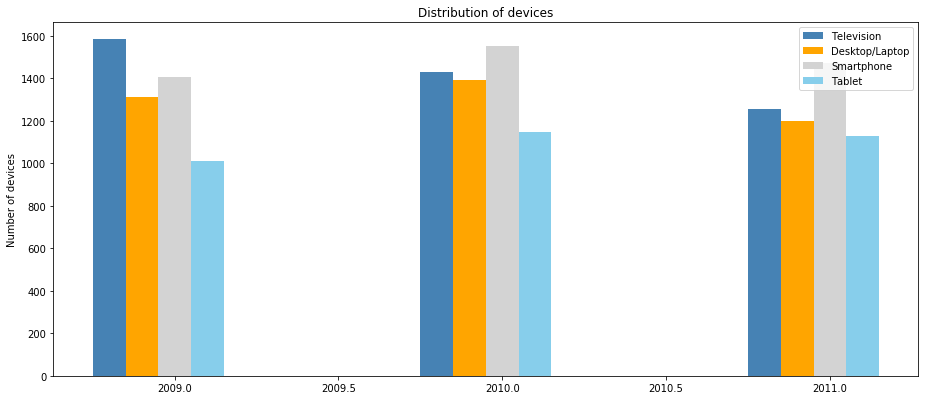

In [49]:
years = mdates.YearLocator()   # every year

fig, ax = plt.subplots()
w = 0.1
s_tv = ax.bar(s_television.index.year-0.2,s_television, width = w,color='steelblue',label ='Television')
s_dp = ax.bar(s_television.index.year-0.1,s_desktop, width = w,color='orange',label ='Desktop/Laptop')
s_dp = ax.bar(s_television.index.year,s_mobile,width = w,color='lightgrey',label ='Smartphone')
s_tb = ax.bar(s_television.index.year+0.1,s_tablet,width = w,color='skyblue',label ='Tablet')

plt.legend(loc='best')
plt.title('Distribution of devices')
plt.ylabel('Number of devices')
plt.gcf().set_size_inches(15.5, 6.5)
plt.show(block=False)


Since absolute numbers might not be the best indicators of changing trends among changing population we map the percentage distribution of devices.

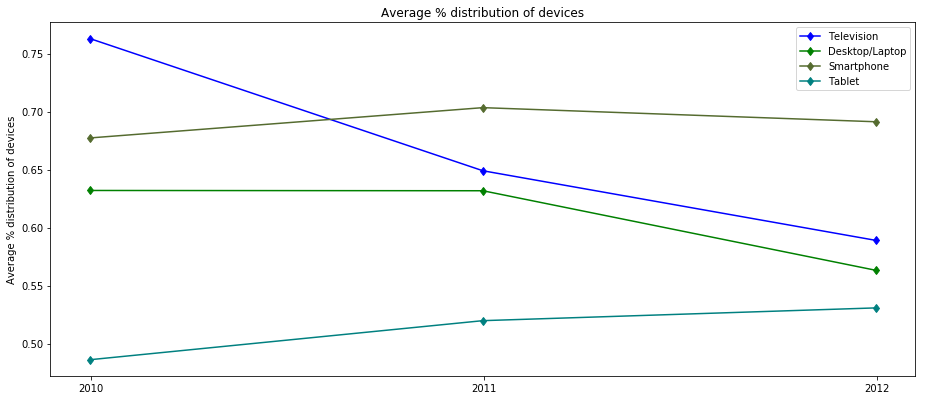

In [50]:
years = mdates.YearLocator()   # every year

fig, ax = plt.subplots()

m_tv = ax.plot(m_television, color='blue',label ='Television',marker = 'd')
m_dp = ax.plot(m_desktop, color='green',label ='Desktop/Laptop',marker = 'd')
m_dp = ax.plot(m_mobile, color='darkolivegreen',label ='Smartphone',marker = 'd')
m_tb = ax.plot(m_tablet, color='teal',label ='Tablet',marker = 'd')

ax.xaxis.set_major_locator(years)

plt.legend(loc='best')
plt.title('Average % distribution of devices')
plt.ylabel('Average % distribution of devices')
plt.gcf().set_size_inches(15.5, 6.5)
plt.show(block=False)

plt.show()

From the above plots, we can observe a steady decline in the usage pattern of television. People tend to increasingly use smartphone for media consumption and the tablet devices are in the race to catch up


### Movie consumption over time

We now want to see how the consumption of media content changes over time. We first look at the movies

In [51]:
#movie in mobile
mov_smartphone = ts_cumres['smartphone_mov'].resample('A').mean()

#movie in tablet
mov_tablet = ts_cumres['tablet_mov'].resample('A').mean()

#movie in laptop
mov_laptop = ts_cumres['laptop_mov'].resample('A').mean()

#movie in tv
mov_tv = ts_cumres['tv_mov'].resample('A').mean()

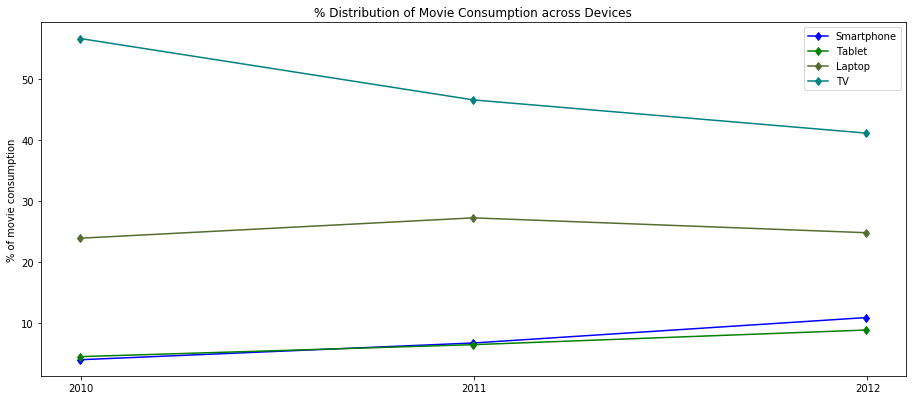

In [65]:
years = mdates.YearLocator()   # every year

fig, ax = plt.subplots()

#mov_smartphone.plot()
m_ph = ax.plot(mov_smartphone, color='blue',label ='Smartphone',marker = 'd')
m_tb = ax.plot(mov_tablet, color='green',label ='Tablet',marker = 'd')
m_lp = ax.plot(mov_laptop, color='darkolivegreen',label ='Laptop',marker = 'd')
m_tv = ax.plot(mov_tv, color='teal',label ='TV',marker = 'd')

ax.xaxis.set_major_locator(years)

plt.legend(loc='best')
plt.title('% Distribution of Movie Consumption across Devices')
plt.ylabel('% of movie consumption')
plt.gcf().set_size_inches(15.5, 6.5)
plt.show(block=False)


plt.show()


Though smartphones and tablets are widely used for media consumption, a large segment of the population still prefers television to watch movies. Smartphones usage appears to be growing with consumers that watch movies.


### Sports Consumption
Now we explore the changes in sports consumption across time.

In [53]:
#sport in mobile
spt_smartphone = ts_cumres['smartphone_sports'].resample('A').mean()

#sport in tablet
spt_tablet = ts_cumres['tablet_sports'].resample('A').mean()

#sport in laptop
spt_laptop = ts_cumres['laptop_sports'].resample('A').mean()

#sport in tv
spt_tv = ts_cumres['tv_sports'].resample('A').mean()

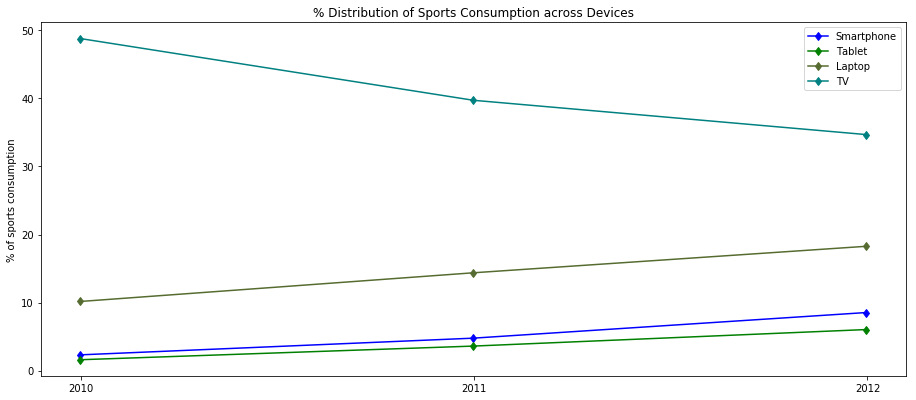

In [64]:
fig, ax = plt.subplots()

#mov_smartphone.plot()
s_ph = ax.plot(spt_smartphone, color='blue',label ='Smartphone',marker = 'd')
s_tb = ax.plot(spt_tablet, color='green',label ='Tablet',marker = 'd')
s_lp = ax.plot(spt_laptop, color='darkolivegreen',label ='Laptop',marker = 'd')
s_tv = ax.plot(spt_tv, color='teal',label ='TV',marker = 'd')


ax.xaxis.set_major_locator(years)

plt.legend(loc='best')
plt.title('% Distribution of Sports Consumption across Devices')
plt.ylabel('% of sports consumption')
plt.gcf().set_size_inches(15.5, 6.5)
plt.show(block=False)

plt.show()


Though large number of people still watch sports on television, this pattern is facing a negative trend. However, laptops, tablets and smartphones are widely being used by people to follow sports. This can be observed in positive trend on the plot above.

### TV Consumption
We now explore changes in TV consumption over time

In [55]:
#Tv show in mobile
tv_shw_smartphone = ts_cumres['smartphone_tv_shw'].resample('A').mean()

#Tv show in tablet
tv_shw_tablet = ts_cumres['tablet_tv_shw'].resample('A').mean()

#Tv show in laptop
tv_shw_laptop = ts_cumres['laptop_tv_shw'].resample('A').mean()

#Tv show in tv
tv_shw_tv = ts_cumres['tv_tv_shw'].resample('A').mean()

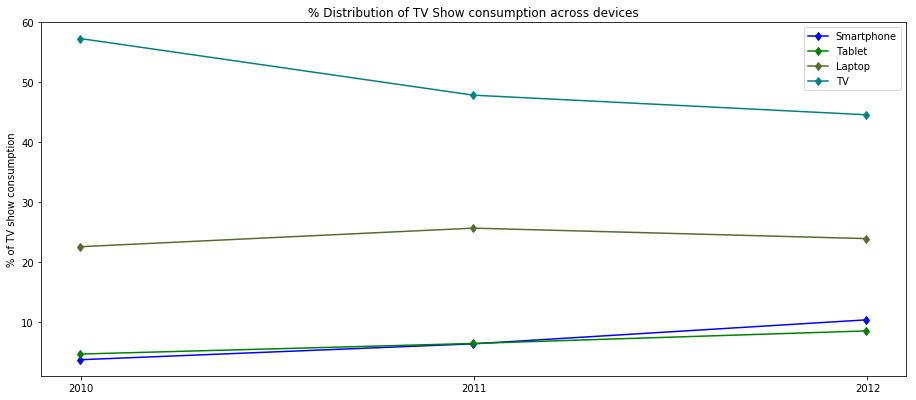

In [63]:
fig, ax = plt.subplots()

#mov_smartphone.plot()
tv_ph = ax.plot(tv_shw_smartphone, color='blue',label ='Smartphone',marker = 'd')
tv_tb = ax.plot(tv_shw_tablet, color='green',label ='Tablet',marker = 'd')
tv_lp = ax.plot(tv_shw_laptop, color='darkolivegreen',label ='Laptop',marker = 'd')
tv_tv = ax.plot(tv_shw_tv, color='teal',label ='TV',marker = 'd')


ax.xaxis.set_major_locator(years)

plt.legend(loc='best')
plt.title('% Distribution of TV Show consumption across devices')
plt.ylabel('% of TV show consumption')
plt.gcf().set_size_inches(15.5, 6.5)
plt.show(block=False)


plt.show()


Majority of the population still watch TV shows on television. However this usage pattern is gradually reducing and the smartdevice usage is slowly increaing (very similarily to movies pointing to similar patterns in both areas)

In [57]:
del ts_cumres['Streaming_media_box']
del ts_cumres['Portable_streaming_thumb_drive']
ts_cumres

,age,state,region,emp_status,children,annual_sal,Television,Desktop,laptop,smartphone_mov,...,smartphone_sports,tablet_sports,laptop_sports,tv_sports,smartphone_tv_shw,tablet_tv_shw,laptop_tv_shw,tv_tv_shw,Tablet,Smartphone
year,,,,,,,,,,,,,,,,,,,,,
2009-01-01,24-29,California,West,Unemployed,No,"$50,000 to $99,999",0,0,1,30,...,-1,-1,-1,-1,0,0,100,0,1,1
2009-01-01,30-46,New York,Northeast,Unemployed,Yes,"$50,000 to $99,999",1,1,0,0,...,0,0,2,98,0,0,1,99,0,0
2009-01-01,24-29,Nevada,West,Employed full-time or part-time,No,"$50,000 to $99,999",1,1,1,20,...,0,0,15,85,0,0,40,60,0,1
2009-01-01,47-65,New Jersey,Northeast,Self-employed,No,"$100,000 to $299,999",1,0,1,10,...,0,0,1,99,5,5,15,75,1,1
2009-01-01,14-23,Arkansas,South,Unemployed,No,"Less than $29,999",1,0,1,0,...,-1,-1,-1,-1,0,0,50,50,0,1
2009-01-01,14-23,New York,Northeast,Employed full-time or part-time,No,Do not know,1,0,1,0,...,-1,-1,-1,-1,0,0,0,100,0,1
2009-01-01,66 or older,Texas,South,Retired,No,"$30,000 to $49,999",1,0,1,0,...,0,0,0,100,0,0,5,95,0,0
2009-01-01,30-46,Missouri,Midwest,Employed full-time or part-time,No,"Less than $29,999",1,1,1,0,...,0,0,0,100,-1,-1,-1,-1,0,1
2009-01-01,47-65,New York,Northeast,Retired,No,"$50,000 to $99,999",1,1,0,0,...,-1,-1,-1,-1,0,0,0,100,0,0


### Normalize the data
Since the data depicts frequency distribution of population's choice of programs on various devices. it is hard to do any analysis on this data. Hence, we find the weighted average of the user's choice, to measure their affinity for various programs across devices.

In [58]:
# Standardize viewers choice of Movies accross devices
ts_cumres['smartphone_mov'] /=100
ts_cumres['laptop_mov'] /=100
ts_cumres['tablet_mov'] /=100
ts_cumres['tv_mov'] /=100

# Standardize viewers choice of sports accross devices
ts_cumres['smartphone_sports'] /=100
ts_cumres['laptop_sports'] /=100
ts_cumres['tablet_sports'] /=100
ts_cumres['tv_sports'] /=100

# Standardize viewers choice of TV Shows accross devices
ts_cumres['smartphone_tv_shw'] /=100
ts_cumres['laptop_tv_shw'] /=100
ts_cumres['tablet_tv_shw'] /=100
ts_cumres['tv_tv_shw'] /=100

In [59]:
ts_cumres

,age,state,region,emp_status,children,annual_sal,Television,Desktop,laptop,smartphone_mov,...,smartphone_sports,tablet_sports,laptop_sports,tv_sports,smartphone_tv_shw,tablet_tv_shw,laptop_tv_shw,tv_tv_shw,Tablet,Smartphone
year,,,,,,,,,,,,,,,,,,,,,
2009-01-01,24-29,California,West,Unemployed,No,"$50,000 to $99,999",0,0,1,0.30,...,-0.01,-0.01,-0.01,-0.01,0.00,0.00,1.00,0.00,1,1
2009-01-01,30-46,New York,Northeast,Unemployed,Yes,"$50,000 to $99,999",1,1,0,0.00,...,0.00,0.00,0.02,0.98,0.00,0.00,0.01,0.99,0,0
2009-01-01,24-29,Nevada,West,Employed full-time or part-time,No,"$50,000 to $99,999",1,1,1,0.20,...,0.00,0.00,0.15,0.85,0.00,0.00,0.40,0.60,0,1
2009-01-01,47-65,New Jersey,Northeast,Self-employed,No,"$100,000 to $299,999",1,0,1,0.10,...,0.00,0.00,0.01,0.99,0.05,0.05,0.15,0.75,1,1
2009-01-01,14-23,Arkansas,South,Unemployed,No,"Less than $29,999",1,0,1,0.00,...,-0.01,-0.01,-0.01,-0.01,0.00,0.00,0.50,0.50,0,1
2009-01-01,14-23,New York,Northeast,Employed full-time or part-time,No,Do not know,1,0,1,0.00,...,-0.01,-0.01,-0.01,-0.01,0.00,0.00,0.00,1.00,0,1
2009-01-01,66 or older,Texas,South,Retired,No,"$30,000 to $49,999",1,0,1,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.05,0.95,0,0
2009-01-01,30-46,Missouri,Midwest,Employed full-time or part-time,No,"Less than $29,999",1,1,1,0.00,...,0.00,0.00,0.00,1.00,-0.01,-0.01,-0.01,-0.01,0,1
2009-01-01,47-65,New York,Northeast,Retired,No,"$50,000 to $99,999",1,1,0,0.00,...,-0.01,-0.01,-0.01,-0.01,0.00,0.00,0.00,1.00,0,0


### We now explore how the popularity of different media changes across the years
#### Data Cleaning

In [60]:
# Reorder the columns of dataframe for the convenience of analysis
reordered =['age', 'state', 'region', 'emp_status', 'children', 'annual_sal',
            'Television', 'Desktop', 'laptop','Tablet', 'Smartphone', 'smartphone_mov', 'tablet_mov',
            'laptop_mov', 'tv_mov', 'smartphone_sports', 'tablet_sports',
            'laptop_sports', 'tv_sports', 'smartphone_tv_shw', 'tablet_tv_shw','laptop_tv_shw', 'tv_tv_shw']

ts_cumres = ts_cumres[reordered]

ts_cumres.loc[ts_cumres['smartphone_mov'] < 0, 'smartphone_mov'] = 0
ts_cumres.loc[ts_cumres['smartphone_sports'] < 0, 'smartphone_sports']  = 0
ts_cumres.loc[ts_cumres['smartphone_tv_shw'] < 0, 'smartphone_tv_shw']  = 0

ts_cumres.loc[ts_cumres['tablet_mov'] < 0, 'tablet_mov'] = 0
ts_cumres.loc[ts_cumres['tablet_sports'] < 0, 'tablet_sports']  = 0
ts_cumres.loc[ts_cumres['tablet_tv_shw'] < 0, 'tablet_tv_shw']  = 0

ts_cumres.loc[ts_cumres['laptop_mov'] < 0, 'laptop_mov'] = 0
ts_cumres.loc[ts_cumres['laptop_sports'] < 0, 'laptop_sports']  = 0
ts_cumres.loc[ts_cumres['laptop_tv_shw'] < 0, 'laptop_tv_shw']  = 0

ts_cumres.loc[ts_cumres['laptop_mov'] < 0, 'laptop_mov'] = 0
ts_cumres.loc[ts_cumres['laptop_sports'] < 0, 'laptop_sports']  = 0
ts_cumres.loc[ts_cumres['laptop_tv_shw'] < 0, 'laptop_tv_shw']  = 0


ts_cumres.loc[ts_cumres['tv_mov'] < 0, 'tv_mov'] = 0
ts_cumres.loc[ts_cumres['tv_sports'] < 0, 'tv_sports']  = 0
ts_cumres.loc[ts_cumres['tv_tv_shw'] < 0, 'tv_tv_shw']  = 0


ts_cumres['movie_pref'] =   ts_cumres['smartphone_mov']+ts_cumres['tablet_mov']+ts_cumres['laptop_mov']+ts_cumres['tv_mov']
ts_cumres['sports_pref'] =  ts_cumres['smartphone_sports']+ts_cumres['tablet_sports']+ts_cumres['laptop_sports']+ts_cumres['tv_sports']
ts_cumres['tv_shw_pref'] =  ts_cumres['smartphone_tv_shw']+ts_cumres['tablet_tv_shw']+ts_cumres['laptop_tv_shw']+ts_cumres['tv_tv_shw']
ts_cumres.head()

,age,state,region,emp_status,children,annual_sal,Television,Desktop,laptop,Tablet,...,tablet_sports,laptop_sports,tv_sports,smartphone_tv_shw,tablet_tv_shw,laptop_tv_shw,tv_tv_shw,movie_pref,sports_pref,tv_shw_pref
year,,,,,,,,,,,,,,,,,,,,,
2009-01-01,24-29,California,West,Unemployed,No,"$50,000 to $99,999",0,0,1,1,...,0.0,0.00,0.00,0.00,0.00,1.00,0.00,1.0,0.0,1.0
2009-01-01,30-46,New York,Northeast,Unemployed,Yes,"$50,000 to $99,999",1,1,0,0,...,0.0,0.02,0.98,0.00,0.00,0.01,0.99,1.0,1.0,1.0
2009-01-01,24-29,Nevada,West,Employed full-time or part-time,No,"$50,000 to $99,999",1,1,1,0,...,0.0,0.15,0.85,0.00,0.00,0.40,0.60,1.0,1.0,1.0
2009-01-01,47-65,New Jersey,Northeast,Self-employed,No,"$100,000 to $299,999",1,0,1,1,...,0.0,0.01,0.99,0.05,0.05,0.15,0.75,1.0,1.0,1.0
2009-01-01,14-23,Arkansas,South,Unemployed,No,"Less than $29,999",1,0,1,0,...,0.0,0.00,0.00,0.00,0.00,0.50,0.50,1.0,0.0,1.0


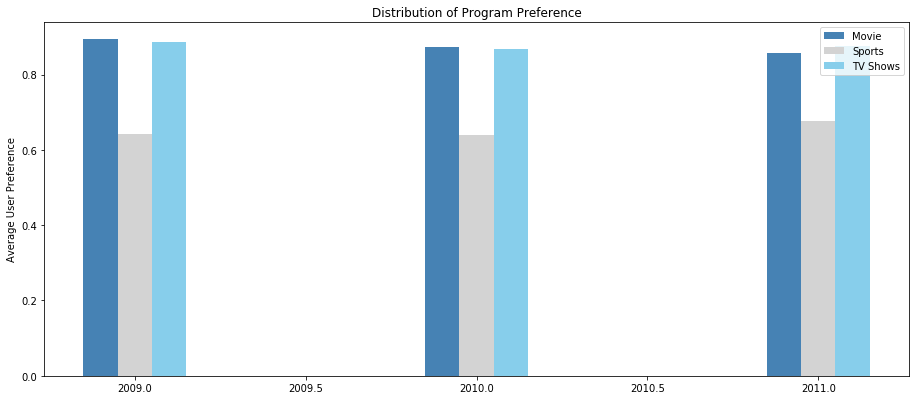

In [67]:
#movie 
movie_pref = ts_cumres['movie_pref'].resample('A').mean()

#Sports
sports_pref = ts_cumres['sports_pref'].resample('A').mean()

#tv show 
tv_show_pref = ts_cumres['tv_shw_pref'].resample('A').mean()

#Distribution of program preference
years = mdates.YearLocator()   # every year
fig, ax = plt.subplots()

# avaerage distribution of program preference
width = 0.1
m1_ph = ax.bar(movie_pref.index.year-0.1,movie_pref, color='steelblue',width = w,label ='Movie')
s1_tb = ax.bar(sports_pref.index.year,sports_pref, color='lightgrey',width = w,label ='Sports')
t1_lp = ax.bar(tv_show_pref.index.year+0.1,tv_show_pref, color='skyblue',width = w,label ='TV Shows')
plt.legend(loc='best')
plt.title('Distribution of Program Preference')
plt.ylabel('Average User Preference')
plt.gcf().set_size_inches(15.5, 6.5)
plt.show()

Based on the information shown above we see that Movies and TV Shows follow a very similar pattern, while sports are much less preferred.

<Figure size 1116x468 with 0 Axes>

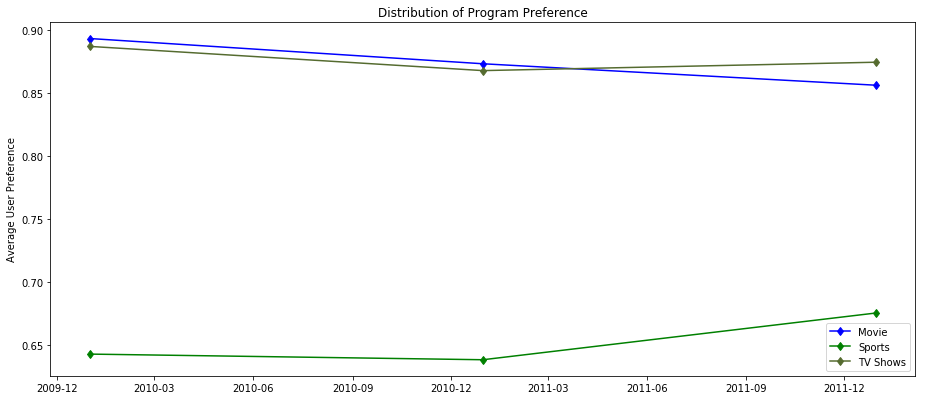

In [68]:
plt.gcf().set_size_inches(15.5, 6.5)
plt.show(block=False)

fig, ax = plt.subplots()


# avaerage distribution of program preference
m_ph = ax.plot(movie_pref, color='blue',label ='Movie',marker = 'd')
s_tb = ax.plot(sports_pref, color='green',label ='Sports',marker = 'd')
t_lp = ax.plot(tv_show_pref, color='darkolivegreen',label ='TV Shows',marker = 'd')


#ax.xaxis.set_major_locator(years)

plt.legend(loc='best')
plt.title('Distribution of Program Preference')
plt.ylabel('Average User Preference')
plt.gcf().set_size_inches(15.5, 6.5)
plt.show(block=False)


We observe an uptick in sports consumption coupled with a decrease in movie watching over time.